<a href="https://colab.research.google.com/github/Geckomonc/FundamentosDatos/blob/main/proyecto_aula/py_Geraldine_Acevedo_Restrepo_01_avances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación de la fuente de datos y librerías

In [2]:
!pip install rlxutils

Descarga automáticamente el dataset “Bank Marketing” desde el repositorio oficial de UCI.

In [3]:
# Librerías
import urllib.request, zipfile, pandas as pd, io
import seaborn as sns
import matplotlib.pyplot as plt

def load_bank_marketing(variant="main"):
    """
    variant: "main"  -> bank.zip (bank-full.csv)
             "additional" -> bank-additional.zip (bank-additional-full.csv)
    """
    urls = {
        "main": "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip",
        "additional": "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip",
    }
    url = urls[variant]

    # Descargar el ZIP a un archivo temporal
    zip_path, _ = urllib.request.urlretrieve(url)

    # Abrir y localizar el CSV correcto
    with zipfile.ZipFile(zip_path, "r") as z:
        names = z.namelist()
        # candidatos según la variante
        candidates = []
        if variant == "main":
            candidates = [n for n in names if n.lower().endswith("bank-full.csv")]
        else:
            candidates = [n for n in names if n.lower().endswith("bank-additional-full.csv")]

        # fallback por si cambia la estructura
        if not candidates:
            candidates = [n for n in names if n.lower().endswith(".csv")]
            if not candidates:
                raise FileNotFoundError("No se encontró ningún CSV dentro del ZIP.")

        with z.open(candidates[0]) as f:
            df = pd.read_csv(f, sep=';')  # este dataset usa ';' como separador
    return df

df = load_bank_marketing("main")        # bank-full.csv (45211 filas, 16 columnas)

## Descripción de la base de datos

In [4]:
# Visualizar una pequeña muestra de los datos
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# Número de registros y variables
print(f"Número de registros: {df.shape[0]}")
print(f"Número de variables: {df.shape[1]}")

Número de registros: 45211
Número de variables: 17


In [6]:
# Tipos de datos
print("\nTipos de datos por variable:")
print(df.dtypes.value_counts())


Tipos de datos por variable:
object    10
int64      7
Name: count, dtype: int64


In [7]:
# Clasificación de variables
categoricas = df.select_dtypes(include=['object']).columns.tolist()
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("🔹 Variables categóricas:")
print("\n".join([f"- {col}" for col in categoricas]))

print("\n🔸 Variables numéricas:")
print("\n".join([f"- {col}" for col in numericas]))

🔹 Variables categóricas:
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- poutcome
- y

🔸 Variables numéricas:
- age
- balance
- day
- duration
- campaign
- pdays
- previous


In [8]:
# Descripción general
print("\nDescripción de variables numéricas:")
print(df.describe())


Descripción de variables numéricas:
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0

In [9]:
# Conteo de valores faltantes ordenado de mayor a menor
faltantes = df.isnull().sum().sort_values(ascending=False)

print("\nConteo de valores faltantes por variable:")
print(faltantes[faltantes > 0])  # Solo muestra variables con al menos un valor faltante


Conteo de valores faltantes por variable:
Series([], dtype: int64)


In [10]:
# Conteo de valores únicos por variable
print("\nConteo de valores únicos por variable:")
print(df.nunique().sort_values(ascending=False))


Conteo de valores únicos por variable:
balance      7168
duration     1573
pdays         559
age            77
campaign       48
previous       41
day            31
month          12
job            12
poutcome        4
education       4
marital         3
contact         3
loan            2
housing         2
default         2
y               2
dtype: int64


# 1. Selección y Documentación de Variables

Para el análisis exploratorio se seleccionaron tres variables continuas (age, balance, duration) y tres variables categóricas (marital, education, housing) del dataset original de campañas de marketing bancario.
Estas variables fueron escogidas porque permiten analizar tanto el perfil socioeconómico del cliente como su comportamiento financiero y de interacción con la campaña.

- Las variables continuas facilitan estudiar la distribución de características individuales (edad), la situación financiera promedio (saldo bancario) y la duración de las llamadas, un factor directamente vinculado al éxito de la campaña.

- Las variables categóricas permiten explorar patrones demográficos y económicos, como el impacto del estado civil, el nivel educativo y la tenencia de crédito hipotecario sobre las decisiones del cliente.

En conjunto, estas seis variables proporcionan una visión equilibrada entre factores personales, financieros y de comportamiento, lo que las convierte en un subconjunto representativo y relevante para identificar relaciones con la decisión final de suscribir un depósito a plazo fijo.

| **Variable**  | **Tipo**             | **Definición**                                                                                             | **Fuente**         |
| :------------ | :------------------- | :--------------------------------------------------------------------------------------------------------- | :----------------- |
| **age**       | Continua (años)      | Edad del cliente en años.                                                                                  | UCI Bank Marketing |
| **balance**   | Continua (euros)     | Saldo promedio anual de la cuenta bancaria (puede ser negativo o positivo).                                | UCI Bank Marketing |
| **duration**  | Continua (segundos)  | Duración de la última llamada de contacto en la campaña de marketing (en segundos).                        | UCI Bank Marketing |
| **marital**   | Discreta (categoría) | Estado civil del cliente (por ejemplo: *single*, *married*, *divorced*, *unknown*).                        | UCI Bank Marketing |
| **education** | Discreta (categoría) | Nivel de educación alcanzado por el cliente (por ejemplo: *primary*, *secondary*, *tertiary* o *unknown*). | UCI Bank Marketing |
| **housing**   | Discreta (binaria)   | Indica si el cliente tiene un préstamo de vivienda (*yes* = sí, *no* = no).                                | UCI Bank Marketing |


# 2. Análisis Univariado

Ahora lo que hare será explorar cada variable individualmente mediante estadísticos descriptivos y visualizaciones univariadas, para entender su distribución y valores típicos. Luego calcularé la asimetría (skewness) y curtosis (kurtosis) de las variables continuas para evaluar la forma de sus distribuciones.

## 2.1 Estadísticos Descriptivos

Comenzamos obteniendo estadísticas descriptivas básicas: conteo de datos no nulos, media, mediana, moda, desviación estándar, mínimo y máximo, entre otros

In [11]:
# Seleccionar las columnas de interés
vars_continuas = ['age', 'balance', 'duration']
vars_discretas = ['marital', 'education', 'housing']

# Estadísticos descriptivos para variables continuas
print(df[vars_continuas].describe().T)


            count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   

               max  
age           95.0  
balance   102127.0  
duration    4918.0  


Nota: En el dataset, la duración mínima aparece como 0 segundos en algunos registros, lo cual podría indicar llamadas no efectivas o ausencias de contacto.


## Interpretaciones

- age (edad): El cliente más joven tiene 18 años y el de mayor edad 95 años.
La edad promedio es ~40.9 años, con una mediana de 39 años y una desviación estándar de ~10.6.
Esto indica que la mayoría de los clientes se concentran alrededor de la mediana, en un rango intercuartílico de 33 a 48 años, mostrando una distribución ligeramente sesgada hacia valores mayores (ya que la media es un poco superior a la mediana).

- balance (saldo anual promedio): El saldo anual promedio de las cuentas es de €1362, con una mediana de €448 y una alta desviación estándar (~€3045).
Esto revela una gran dispersión en los saldos, donde la mitad de los clientes tienen menos de €448, pero existen valores extremos tanto negativos como positivos.
Los saldos van desde un mínimo de –€8019 (posiblemente sobregiros o deudas) hasta un máximo de €102 127, que corresponde a clientes con depósitos excepcionalmente altos. La diferencia entre la media (€1362) y la mediana (€448) confirma una distribución fuertemente sesgada a la derecha (cola larga positiva), causada por unos pocos clientes con saldos muy elevados.
Aunque los valores negativos son poco frecuentes, demuestran que existen cuentas con déficit o sobregiro dentro del banco. Conclusión: la mayoría de los clientes mantiene saldos moderados, pero el alto desvío estándar y el rango tan amplio (más de 110 000 € entre mínimo y máximo) indican una alta desigualdad financiera entre los clientes.

- duration (duración de la última llamada): La duración de las llamadas varía desde 0 segundos (llamadas no efectivas o sin contacto) hasta un máximo de 4918 segundos (≈ 82 minutos).
La media es de 258 s (~4.3 minutos), la mediana de 180 s (3 minutos), y el rango intercuartílico va de 103 a 319 s.
Esto sugiere que la mayoría de las llamadas son relativamente cortas (entre 1,5 y 5 minutos), aunque algunas pocas llamadas muy extensas elevan el promedio general. La asimetría es nuevamente positiva, con una cola larga hacia la derecha debido a las llamadas excepcionalmente largas.
Conclusión: lo anterior implica que la duración típica de una llamada es breve, pero existen contactos más prolongados —quizás asociados a clientes interesados o negociaciones más complejas— que afectan la media global.

In [ ]:
# Tabla resumen
resumen_data = {
    "Variable": ["Age", "Balance", "Duration"],
    "Distribución": [
        "Levemente sesgada a la derecha",
        "Fuertemente sesgada a la derecha",
        "Muy sesgada a la derecha"
    ],
    "Rasgo destacado": [
        "Predominan adultos entre 30 y 50 años",
        "Alta dispersión; algunos clientes con saldos extremos (−8019 € a 102127 €)",
        "Llamadas típicamente cortas pero con algunos valores atípicos muy largos"
    ]
}

resumen_df = pd.DataFrame(resumen_data)

# Mostrar tabla
print("Resumen interpretativo de variables continuas:")
display(
    resumen_df.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

Resumen interpretativo de variables continuas:


,Variable,Distribución,Rasgo destacado
0,Age,Levemente sesgada a la derecha,Predominan adultos entre 30 y 50 años
1,Balance,Fuertemente sesgada a la derecha,Alta dispersión; algunos clientes con saldos extremos (−8019 € a 102127 €)
2,Duration,Muy sesgada a la derecha,Llamadas típicamente cortas pero con algunos valores atípicos muy largos


In [ ]:
total_clientes = len(df)
negativos = (df['balance'] < 0).sum()
cero = (df['balance'] == 0).sum()
positivos = (df['balance'] > 0).sum()

# Crear un resumen
resumen_balance = pd.DataFrame({
    "Tipo de saldo": ["Negativo", "Cero", "Positivo"],
    "Cantidad de clientes": [negativos, cero, positivos],
    "Porcentaje (%)": [
        round(negativos / total_clientes * 100, 2),
        round(cero / total_clientes * 100, 2),
        round(positivos / total_clientes * 100, 2)
    ]
})

print("Distribución de clientes según el tipo de saldo (balance):")
display(
    resumen_balance.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

Distribución de clientes según el tipo de saldo (balance):


,Tipo de saldo,Cantidad de clientes,Porcentaje (%)
0,Negativo,3766,8.330000
1,Cero,3514,7.770000
2,Positivo,37931,83.900000


In [ ]:
# Tablas de frecuencia para variables discretas
for var in vars_discretas:
  print(f"\nFrecuencias de {var}:")
  print(df[var].value_counts())


Frecuencias de marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Frecuencias de education:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Frecuencias de housing:
housing
yes    25130
no     20081
Name: count, dtype: int64


## Interpretaciones

- marital (estado civil): El conjunto de datos muestra que la mayoría de los clientes están casados (27 214 registros), seguidos por solteros (12 790) y divorciados (5 207). Esto indica que alrededor del 60% de los clientes son casados, mientras que los solteros representan aproximadamente 28% y los divorciados el 12%.
Esta distribución sugiere que la campaña del banco alcanzó principalmente a adultos con estabilidad familiar, posiblemente porque este grupo tiende a tener mayor poder adquisitivo o disposición a invertir.
La categoría unknown no aparece, lo que significa que todos los clientes reportaron su estado civil.

- education (nivel educativo): Los datos indican que la mayoría de los clientes tienen educación secundaria (23 202 registros, ~51%), seguida de educación terciaria o universitaria (13 301, ~29%).
Un grupo menor posee educación primaria (6 851, ~15%), y una fracción pequeña no reportó su nivel educativo (1 857, ~4%).
Esto evidencia una predominancia de clientes con formación media o superior.

- housing (préstamo de vivienda): Se observa que 25 130 clientes (56%) poseen un préstamo de vivienda (housing = yes), mientras que 20 081 (44%) no lo tienen.
Esto refleja una distribución relativamente equilibrada, aunque con un ligero predominio de quienes tienen créditos hipotecarios.
Este resultado puede asociarse con la edad promedio (~41 años), etapa en la que muchas personas están pagando o adquiriendo vivienda.

In [ ]:
import pandas as pd

# Crear la tabla resumen de variables categóricas
resumen_categoricas = pd.DataFrame({
    "Variable": ["Marital (estado civil)", "Education (nivel educativo)", "Housing (préstamo de vivienda)"],
    "Categorías principales": [
        "married (27,214), single (12,790), divorced (5,207)",
        "secondary (23,202), tertiary (13,301), primary (6,851), unknown (1,857)",
        "yes (25,130), no (20,081)"
    ],
    "Interpretación": [
        "Predominan los clientes casados (~60%), seguidos de solteros (~28%) y divorciados (~12%).",
        "La mayoría tiene educación secundaria (~51%), seguida de universitaria (~29%) y primaria (~15%).",
        "Ligeramente más de la mitad posee préstamo de vivienda (~56%), reflejando estabilidad económica."
    ]
})

# Mostrar la tabla con estilo
print("Síntesis interpretativa de las variables continuas:")
display(
    resumen_categoricas.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)


Síntesis interpretativa de las variables continuas:


,Variable,Categorías principales,Interpretación
0,Marital (estado civil),"married (27,214), single (12,790), divorced (5,207)","Predominan los clientes casados (~60%), seguidos de solteros (~28%) y divorciados (~12%)."
1,Education (nivel educativo),"secondary (23,202), tertiary (13,301), primary (6,851), unknown (1,857)","La mayoría tiene educación secundaria (~51%), seguida de universitaria (~29%) y primaria (~15%)."
2,Housing (préstamo de vivienda),"yes (25,130), no (20,081)","Ligeramente más de la mitad posee préstamo de vivienda (~56%), reflejando estabilidad económica."


## 2.2 Visualización de Distribuciones Univariadas

Variables Continuas

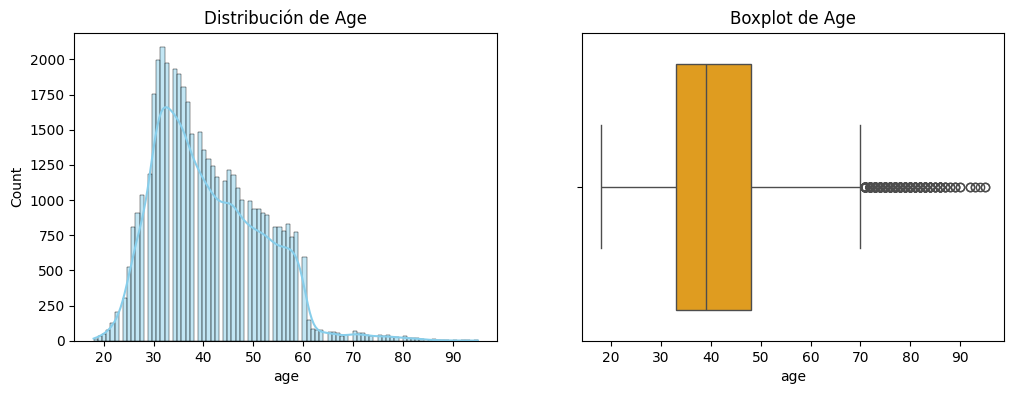

In [ ]:

# Histograma y boxplot para la variable 'age'
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['age'], kde=True, color='skyblue')
plt.title('Distribución de Age')
plt.subplot(1,2,2)
sns.boxplot(x=df['age'], color='orange')
plt.title('Boxplot de Age')
plt.show()


Los gráficos nos permiten confirmar información que ya conociamos gracias al describe que use anteriormente.
age (edad)

El histograma de age muestra una distribución unimodal y ligeramente sesgada hacia la derecha, con un pico principal entre los 30 y 40 años.
La mayoría de los clientes se concentra entre los 33 y 48 años (rango intercuartílico), mientras que los menores de 25 y mayores de 70 son menos frecuentes.
La media (~41 años) es levemente superior a la mediana (39 años), lo que confirma una asimetría positiva moderada, causada por un pequeño grupo de clientes de edad avanzada.

El boxplot refuerza esta observación: la mediana se sitúa cerca del centro de la caja, y se aprecian algunos valores atípicos por encima de los 70 años, representando a clientes de edad muy avanzada, pero reales.

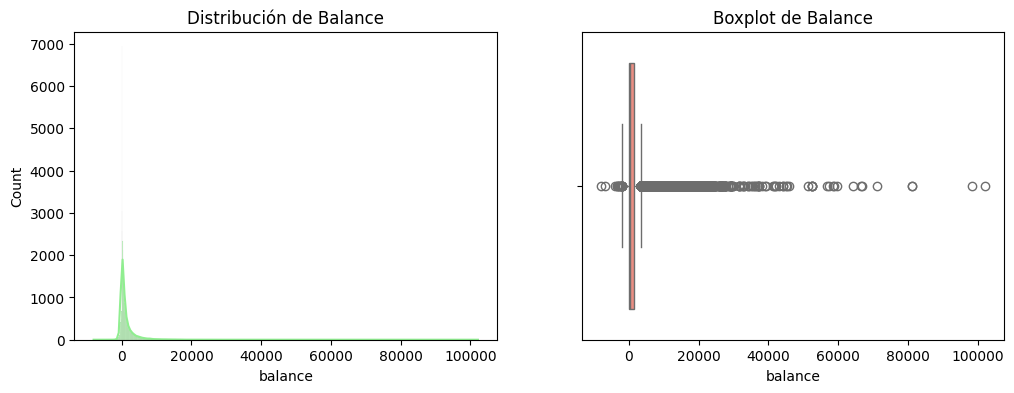

In [ ]:
# Histograma y boxplot para la variable 'balance'
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['balance'], kde=True, color='lightgreen')
plt.title('Distribución de Balance')
plt.subplot(1,2,2)
sns.boxplot(x=df['balance'], color='salmon')
plt.title('Boxplot de Balance')
plt.show()


balance (saldo promedio anual)

La distribución de balance es altamente asimétrica hacia la derecha, con una gran concentración de clientes cerca del cero y una larga cola extendida hacia valores altos.
El histograma evidencia que la mayoría de los clientes mantiene saldos bajos o moderados, mientras que unos pocos presentan saldos muy elevados (superiores a €50 000).
También existen valores negativos, correspondientes a clientes con sobregiros o deudas.

El boxplot muestra una caja muy comprimida cerca del origen y una gran cantidad de outliers positivos dispersos a lo largo del eje, lo cual refleja una alta desigualdad en los saldos.
Esta fuerte asimetría implica que la media (€1362) está influenciada por unos pocos valores extremos, por lo que la mediana (€448) es un mejor indicador de la tendencia central.

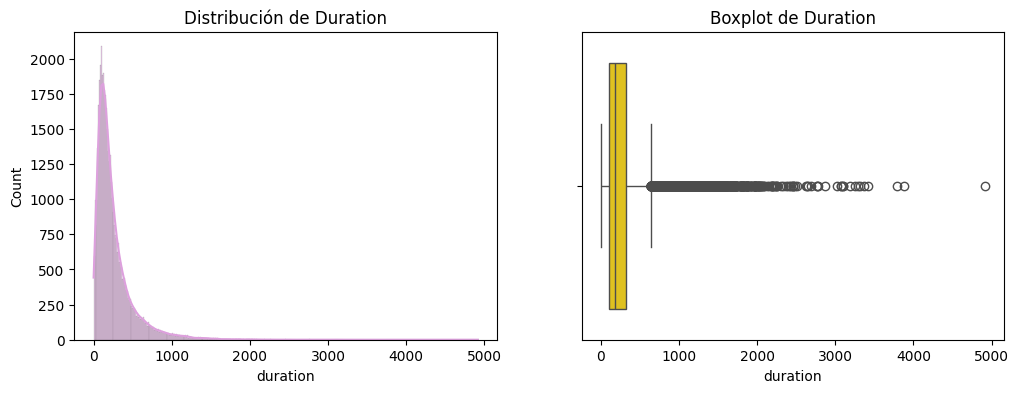

In [ ]:
# Histograma y boxplot para la variable 'duration'
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['duration'], kde=True, color='plum')
plt.title('Distribución de Duration')
plt.subplot(1,2,2)
sns.boxplot(x=df['duration'], color='gold')
plt.title('Boxplot de Duration')
plt.show()


duration (duración de la última llamada)

La variable duration también presenta una distribución asimétrica positiva.
El histograma muestra que la mayoría de las llamadas dura pocos minutos (menores a 300 segundos), mientras que existe una cola larga hacia la derecha debido a llamadas excepcionalmente extensas (hasta 4918 segundos, más de una hora).
Esto indica que, aunque la mediana es de 180 segundos (3 minutos), la media (~258 s) se ve aumentada por unas pocas llamadas muy largas.

El boxplot confirma la presencia de numerosos outliers a la derecha del rango intercuartílico, correspondientes a estos contactos prolongados.

In [ ]:
# Tabla
sintesis_continuas = pd.DataFrame({
    "Variable": ["Age", "Balance", "Duration"],
    "Forma de la distribución": [
        "Ligeramente sesgada a la derecha",
        "Extremadamente sesgada positivamente",
        "Muy asimétrica positiva"
    ],
    "Rasgos destacados": [
        "Adultos entre 30–50 años predominan; pocos clientes mayores (>70) como outliers.",
        "Mayoría con saldos bajos o negativos; pocos valores muy altos elevan la media.",
        "Llamadas cortas son lo común; existen llamadas muy largas que actúan como outliers."
    ]
})

# Mostrar tabla
print("Síntesis interpretativa de las variables continuas:")
display(
    sintesis_continuas.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

Síntesis interpretativa de las variables continuas:


,Variable,Forma de la distribución,Rasgos destacados
0,Age,Ligeramente sesgada a la derecha,Adultos entre 30–50 años predominan; pocos clientes mayores (>70) como outliers.
1,Balance,Extremadamente sesgada positivamente,Mayoría con saldos bajos o negativos; pocos valores muy altos elevan la media.
2,Duration,Muy asimétrica positiva,Llamadas cortas son lo común; existen llamadas muy largas que actúan como outliers.


Variables catégoricas

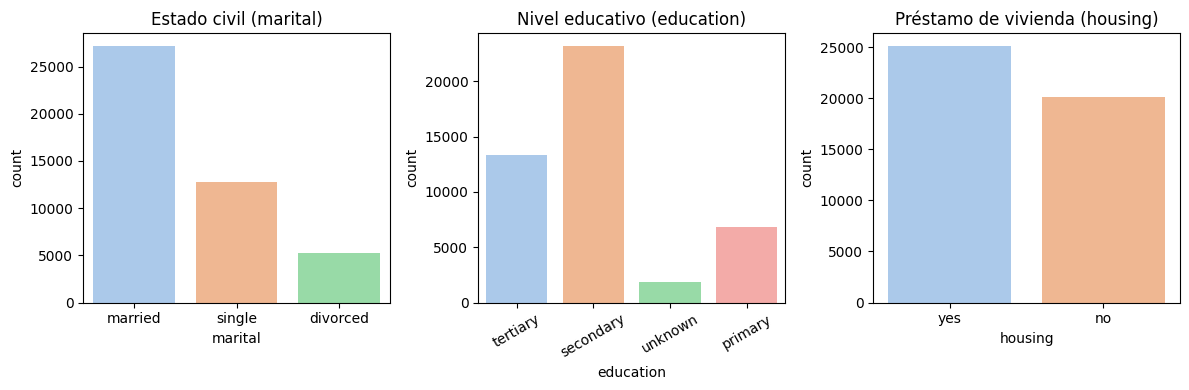

In [ ]:
plt.figure(figsize=(12,4))

# Estado civil (marital)
plt.subplot(1,3,1)
sns.countplot(x='marital', hue='marital', data=df, palette='pastel', legend=False)
plt.title('Estado civil (marital)')

# Nivel educativo (education)
plt.subplot(1,3,2)
sns.countplot(x='education', hue='education', data=df, palette='pastel', legend=False)
plt.title('Nivel educativo (education)')
plt.xticks(rotation=30)

# Préstamo de vivienda (housing)
plt.subplot(1,3,3)
sns.countplot(x='housing', hue='housing', data=df, palette='pastel', legend=False)
plt.title('Préstamo de vivienda (housing)')

plt.tight_layout()
plt.show()


## Interpretación
- marital (estado civil): El gráfico de barras confirma que la categoría married (casados) es la más frecuente, seguida de single (solteros) y divorced (divorciados).
Esto sugiere que la mayoría de los clientes contactados son adultos con estabilidad familiar, un segmento que suele representar mayor capacidad de ahorro y menor rotación financiera.
No se observan valores desconocidos (unknown), lo que indica datos completos y consistentes en esta variable.

- education (nivel educativo): Las barras de secondary (secundaria) y tertiary (universitaria) son las más altas, indicando que la campaña alcanzó principalmente a personas con nivel educativo medio o superior.
Un grupo menor cuenta con educación primaria, y una pequeña proporción está clasificada como unknown.
Esto evidencia que la base de clientes está dominada por personas con formación media o superior, lo cual puede influir en su nivel de ingresos y decisiones financieras.

- housing (préstamo de vivienda): En el gráfico de housing, se observa que yes (sí) presenta una frecuencia ligeramente mayor que no, lo que sugiere que más de la mitad de los clientes tienen un préstamo hipotecario.
Esto puede reflejar un segmento de población económicamente activa en etapas de consolidación patrimonial (compra de vivienda o créditos asociados).

In [ ]:
# Tabla de síntesis interpretativa

sintesis_categoricas = pd.DataFrame({
    "Variable": ["Marital (estado civil)", "Education (nivel educativo)", "Housing (préstamo de vivienda)"],
    "Interpretación": [
        "En marital, los casados predominan ampliamente (~60%), lo que podría sesgar modelos si se usa esta variable como predictor sin balancear.",
        "En education, hay desbalance entre niveles educativos (secundaria y terciaria dominan sobre primaria y unknown), por lo que en etapas de modelado se podría agrupar categorías minoritarias o aplicar alguna técnic de codificación",
        "En housing, la proporción entre yes y no es equilibrada, por lo que de momento no requieriría corrección."
    ]
})

# Mostrar tabla
print("Síntesis interpretativa de las variables categóricas:")
display(
    sintesis_categoricas.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'left'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)



Síntesis interpretativa de las variables categóricas:


,Variable,Interpretación
0,Marital (estado civil),"En marital, los casados predominan ampliamente (~60%), lo que podría sesgar modelos si se usa esta variable como predictor sin balancear."
1,Education (nivel educativo),"En education, hay desbalance entre niveles educativos (secundaria y terciaria dominan sobre primaria y unknown), por lo que en etapas de modelado se podría agrupar categorías minoritarias o aplicar alguna técnic de codificación"
2,Housing (préstamo de vivienda),"En housing, la proporción entre yes y no es equilibrada, por lo que de momento no requieriría corrección."


### ¿Qué se podría hacer?
- Verificar si el predominio de clientes casados afecta la representatividad de otras categorías y, de ser necesario, aplicar técnicas de balanceo en el modelado.
- Unificar o reagrupar categorías con baja frecuencia en educación para evitar ruido estadístico.
- Mantener la variable *housing* sin cambios, ya que su distribución es equilibrada y puede resultar útil para segmentar por estabilidad financiera.

## 2.3 Asimetría y Curtosis


In [ ]:
from scipy.stats import skew, kurtosis
for var in vars_continuas:
  print(f"{var}: skewness = {skew(df[var]):.2f}, kurtosis = {kurtosis(df[var]):.2f}")


age: skewness = 0.68, kurtosis = 0.32
balance: skewness = 8.36, kurtosis = 140.74
duration: skewness = 3.14, kurtosis = 18.15


Estos resultados coinciden con las observaciones gráficas vistas en los histogramas y boxplots:

En age, la asimetría positiva moderada confirma que la mayoría de los clientes se concentran en edades intermedias (30–50 años), mientras unos pocos casos de edad avanzada desplazan la media hacia la derecha. La curtosis baja (≈0.32) indica una forma relativamente normal, con colas apenas más pesadas que la distribución normal estándar.

En balance, los valores son extremos: una asimetría de 8.36 y una curtosis de más de 140 reflejan una concentración masiva de saldos bajos o cercanos a cero, junto con unos pocos clientes con saldos muy altos. Esto explica la larga cola derecha observada en los gráficos y la gran cantidad de outliers. Es, sin duda, la variable con mayor dispersión y concentración de valores extremos del conjunto.

En duration, la asimetría positiva (3.14) y curtosis elevada (18.15) también confirman una distribución con larga cola derecha, donde la mayoría de llamadas duran pocos minutos, pero existen contactos prolongados que elevan la media. Aunque no es tan extrema como balance, sigue presentando alta variabilidad y presencia de valores atípicos.

## Interpretación
Los valores de asimetría y curtosis confirman que las tres variables presentan distribuciones no normales (particularmente balance y duration).
Esto sugiere la necesidad de considerar transformaciones (por ejemplo, log10(balance + constante) o sqrt(duration)) si se desea utilizarlas en modelos paramétricos que asumen normalidad.

Una curtosis tan alta indica que la media y desviación estándar no son representativas del comportamiento de los datos, ya que gran parte de la variabilidad proviene de casos extremos.
En estos casos, es preferible usar la mediana y el rango intercuartílico (IQR) como medidas de tendencia central y dispersión, respectivamente, pues no se ven afectadas por outliers.

### ¿Qué se podría hacer?
- **Aplicar transformaciones** a variables con alta asimetría, como *balance* y *duration*, para reducir la influencia de valores extremos. Se podrían probar transformaciones logarítmicas (log10(balance + constante)) o de raíz cuadrada en *duration*.
- **Usar medidas robustas**, como la mediana y el rango intercuartílico (IQR), en lugar de la media y la desviación estándar, ya que las distribuciones presentan colas pesadas y valores atípicos.
- **Identificar y analizar los outliers** más representativos en *balance* y *duration* para verificar si corresponden a casos reales (clientes con altos saldos o llamadas muy largas) o a errores de registro.
- **Evaluar la normalización o estandarización** de las variables continuas antes de aplicar modelos predictivos, especialmente si se usan algoritmos sensibles a la escala (como regresión lineal o SVM).
- **Conservar la variable *age*** sin transformaciones, ya que su distribución es relativamente estable y no presenta valores extremos problemáticos.


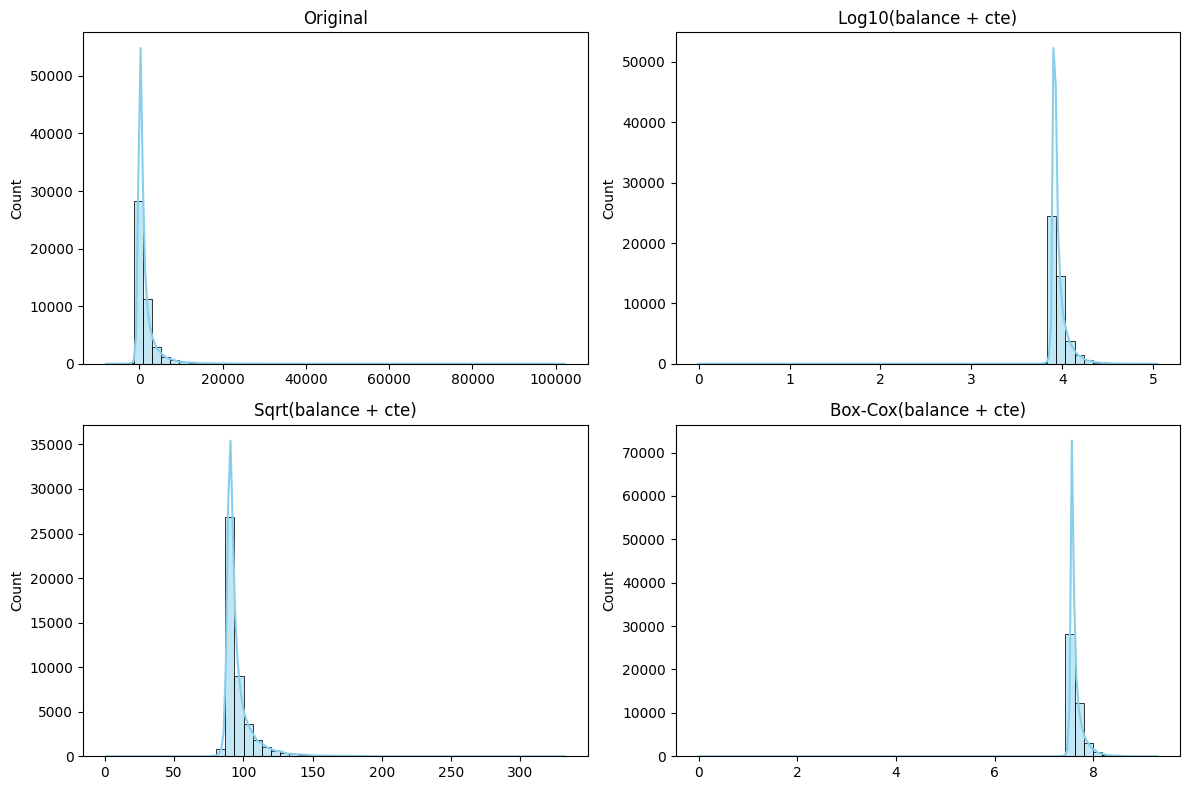

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Copia de seguridad de los datos
balance = df['balance'].copy()

# Ajuste: para evitar log de valores negativos o cero, se suma una constante
cte = abs(balance.min()) + 1
balance_log = np.log10(balance + cte)
balance_sqrt = np.sqrt(balance + cte)

# Box-Cox requiere solo valores positivos
balance_boxcox, _ = stats.boxcox(balance + cte)

# Crear un DataFrame temporal para graficar
transformed_df = {
    'Original': balance,
    'Log10(balance + cte)': balance_log,
    'Sqrt(balance + cte)': balance_sqrt,
    'Box-Cox(balance + cte)': balance_boxcox
}

# Graficar comparativamente los histogramas
plt.figure(figsize=(12,8))
for i, (title, data) in enumerate(transformed_df.items(), 1):
    plt.subplot(2,2,i)
    sns.histplot(data, bins=50, kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel('')
plt.tight_layout()
plt.show()


Interpretación de los gráficos

En mis gráficos se observa lo siguiente:

Original:
La distribución de balance está altamente sesgada a la derecha, con la mayoría de los clientes concentrados cerca de cero y unos pocos con saldos enormes (hasta 100 000 €).
→ Esto confirma la fuerte asimetría y curtosis que he calculado (skewness = 8.36, kurtosis = 140.74).

Log10(balance + cte):
El logaritmo comprime los valores grandes y mejora un poco la escala, pero la distribución sigue muy concentrada, porque el rango de balance es tan extremo que ni siquiera el log logra “normalizarla” completamente.
Aun así, podría ser útil dependiendo del contexto porque reduce la magnitud de los outliers y hace más manejables las diferencias entre clientes promedio y los de saldos altos.

Sqrt(balance + cte):
La raíz cuadrada también reduce la escala, pero su efecto es más suave que el log.
Visualmente, sigue habiendo concentración en valores bajos, aunque la curva se ve un poco más extendida.
Esta transformación puede ser útil cuando los valores no son tan extremos como en este caso, pero aquí su impacto es limitado.

Box-Cox(balance + cte):
Box–Cox ajusta automáticamente un parámetro para tratar de normalizar la variable.
En mi resultado, sigue siendo asimétrica, lo que indica que la distribución original es demasiado extrema para una corrección completa, aunque mejora ligeramente la forma respecto al original.
Es la transformación más flexible, pero también la más sensible a valores extremos y a ceros/negativos.

¿Es útil aplicar alguna de estas transformaciones?
- Es recomendable cuando se planea usar modelos que suponen normalidad o linealidad (por ejemplo, regresión lineal o SVM), ya que una transformación logarítmica puede reducir la influencia de valores extremos y mejorar la estabilidad estadística.
También sirve para comparar clientes en escalas similares, evitando que unos pocos con saldos muy altos distorsionen los promedios.

- No es tan recomendable si se trabaja con modelos no paramétricos (como árboles de decisión o Random Forest), pues estos ya manejan bien los outliers y podrían perder información si la variable se transforma demasiado.
Además, la transformación altera la interpretación económica del saldo, porque los valores dejan de estar expresados en euros y pasan a representar proporciones o factores multiplicativos.

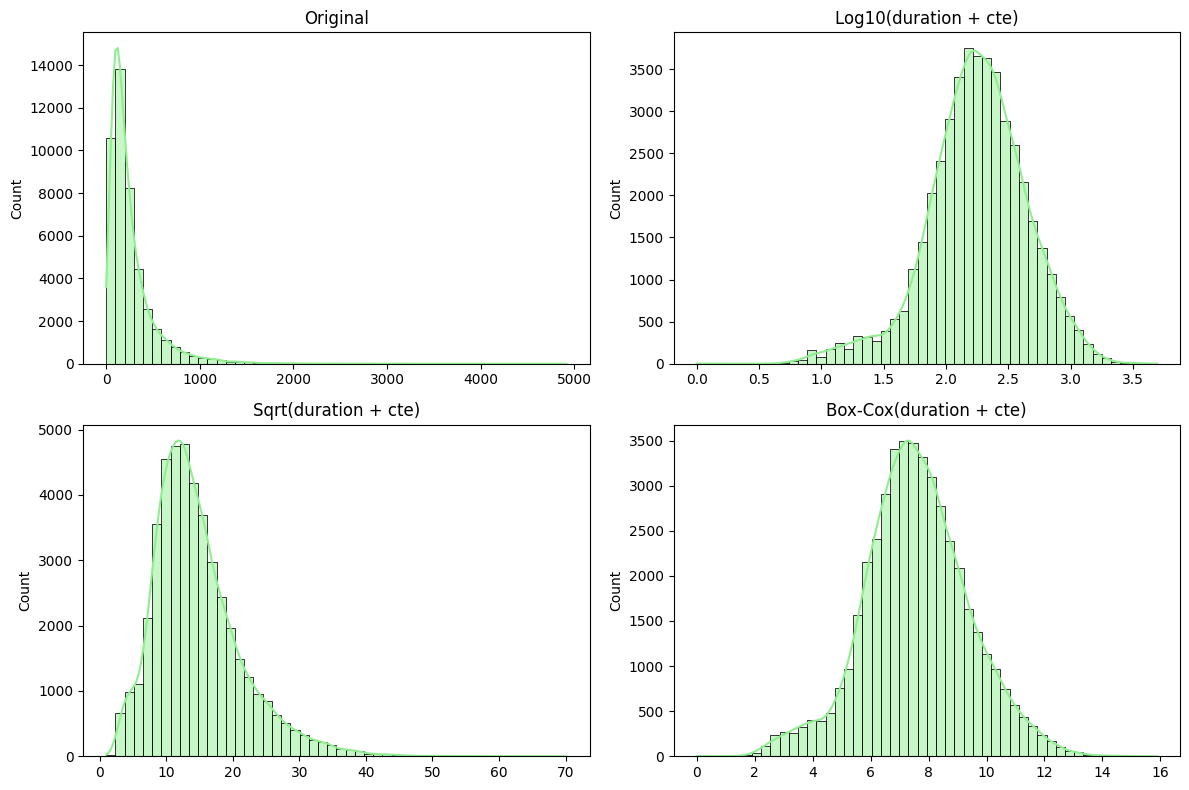

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Copia de la variable duration
duration = df['duration'].copy()

# Ajuste: se suma una constante para evitar log(0)
cte_dur = abs(duration.min()) + 1
duration_log = np.log10(duration + cte_dur)
duration_sqrt = np.sqrt(duration + cte_dur)

# Box-Cox (requiere valores estrictamente positivos)
duration_boxcox, _ = stats.boxcox(duration + cte_dur)

# Crear un DataFrame temporal con todas las transformaciones
transformed_duration = {
    'Original': duration,
    'Log10(duration + cte)': duration_log,
    'Sqrt(duration + cte)': duration_sqrt,
    'Box-Cox(duration + cte)': duration_boxcox
}

# Graficar comparativamente los histogramas
plt.figure(figsize=(12,8))
for i, (title, data) in enumerate(transformed_duration.items(), 1):
    plt.subplot(2,2,i)
    sns.histplot(data, bins=50, kde=True, color='lightgreen')
    plt.title(title)
    plt.xlabel('')
plt.tight_layout()
plt.show()


Interpretación de los gráficos

Original:
La distribución de duration muestra una cola larga hacia la derecha, típica de una variable con alta asimetría positiva.
La mayoría de las llamadas duran pocos segundos o minutos, mientras que unas pocas son excepcionalmente largas (hasta 4 918 s ≈ 82 min).
Esto coincide con los estadísticos que calculaste: skewness = 3.14, kurtosis = 18.15, lo que refleja una distribución con colas pesadas y presencia de outliers.

Log10(duration + cte):
La transformación logarítmica funciona muy bien en este caso:
el histograma ahora muestra una forma mucho más simétrica y centrada, similar a una campana normal.
Los valores largos fueron comprimidos de manera efectiva, reduciendo la dispersión sin eliminar información.
Esta transformación normaliza visualmente la variable y es ideal para usarla en modelos que asumen linealidad o normalidad.

Sqrt(duration + cte):
La raíz cuadrada también suaviza la asimetría, pero el efecto es menor que el del logaritmo.
La distribución mejora, aunque sigue presentando una ligera inclinación hacia la derecha.
Es útil si prefieres una transformación más suave y no quieres alterar demasiado la escala.

Box-Cox(duration + cte):
Box–Cox ajusta automáticamente un parámetro para buscar la forma más normal posible.
En este caso, logra una distribución casi perfectamente simétrica, confirmando que duration se presta bien para este tipo de transformación.
Es la que mejor logra estabilizar la varianza y reducir el sesgo, pero requiere que todos los valores sean positivos (por eso sumamos una constante).


¿Es útil aplicar alguna de estas transformaciones?

Aplicar una transformación a la variable duration es útil y recomendable porque reduce su fuerte asimetría, mejora la normalidad y facilita el uso en modelos estadísticos como regresión o PCA. Además, permite comparar las duraciones en una escala más equilibrada y estable.

Sin embargo, al transformar se pierde la interpretación directa del tiempo (en segundos o minutos), por lo que si se necesita reportar la duración real, habría que reconvertir los valores. En modelos no paramétricos como Random Forest o XGBoost, la transformación no es necesaria, ya que estos manejan bien los valores extremos sin requerir normalidad.

# 3. Análisis Bivariado y Multivariado

- Correlaciones entre variables continuas (edad, saldo, duración), representadas con una matriz
de correlación y mapa de calor.
- Relaciones entre variables continuas y categóricas, por ejemplo comparando distribuciones (boxplots) o tendencias (scatterplots) condicionadas a categorías.
- Relaciones entre variables categóricas entre sí, mediante tablas cruzadas (crosstabs) y pruebas
de asociación (Chi-cuadrado).

Objetivo: Estas exploraciones nos ayudarán a detectar patrones, como si cierta categoría tiende a tener valores
más altos de una variable continua, o si dos medidas numéricas varían conjuntamente

## 3.1 Correlación entre Variables Continuas

               age   balance  duration
age       1.000000  0.097783 -0.004648
balance   0.097783  1.000000  0.021560
duration -0.004648  0.021560  1.000000


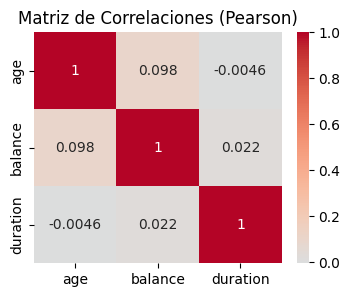

In [12]:
# Calcular matriz de correlación de las variables continuas
corr_matrix = df[vars_continuas].corr(numeric_only=True)
print(corr_matrix)
# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de Correlaciones (Pearson)')
plt.show()

In [14]:

# Tabla de correlaciones entre variables continuas
correlaciones_continuas = pd.DataFrame({
    "Relación": ["age – balance", "age – duration", "balance – duration"],
    "Coeficiente (r)": [0.0978, -0.0046, 0.0216],
    "Interpretación": [
        "Correlación positiva muy débil. Sugiere que los clientes ligeramente mayores tienden a tener saldos un poco más altos, pero la relación es casi nula.",
        "Correlación negativa prácticamente nula. La duración de la llamada no guarda relación con la edad del cliente.",
        "Correlación positiva mínima. No existe una relación lineal apreciable entre el saldo promedio y la duración de las llamadas."
    ]
})

# Mostrar tabla con estilo visual
print("Correlaciones entre variables continuas:")
display(
    correlaciones_continuas.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#d1e7dd'),
            ('color', '#000'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]}
    ])
)

Correlaciones entre variables continuas:


,Relación,Coeficiente (r),Interpretación
0,age – balance,0.097800,"Correlación positiva muy débil. Sugiere que los clientes ligeramente mayores tienden a tener saldos un poco más altos, pero la relación es casi nula."
1,age – duration,-0.004600,Correlación negativa prácticamente nula. La duración de la llamada no guarda relación con la edad del cliente.
2,balance – duration,0.021600,Correlación positiva mínima. No existe una relación lineal apreciable entre el saldo promedio y la duración de las llamadas.


### Interpretación general de las correlaciones

La matriz de correlaciones y el mapa de calor muestran que **no existen relaciones lineales fuertes** entre las variables continuas`age, balance y duration.  
Los coeficientes de Pearson obtenidos son muy bajos (todos los |r| < 0.1), lo que indica **correlaciones débiles o nulas**.

- Entre **age y balance** hay una correlación positiva muy débil , lo que sugiere que los clientes de mayor edad pueden tener saldos ligeramente más altos, aunque la relación es prácticamente insignificante.  
- Entre **age y duration**, la correlación es negativa y casi nula, indicando que la duración de la llamada es **independiente de la edad del cliente**.  
- Entre **balance y duration**, la correlación es positiva mínima, por lo que el saldo promedio no parece influir en cuánto dura la llamada.  

En conjunto, estos valores confirman que las tres variables aportan **información independiente** al análisis y que **no existe colinealidad** entre ellas.  
Esto es útil, ya que cada variable puede considerarse por separado en modelos posteriores sin riesgo de redundancia o duplicación de información.



 Complementare el análisis cuantitativo con diagramas de dispersión
(scatter plots) para visualizar las relaciones. Dado que las correlaciones son bajas, se esperarían nubes de
puntos sin una forma definida.

**NOTA:**  
Dado que el conjunto de datos original contiene más de 45 000 registros, algunas visualizaciones —como los scatter plots o los boxplots— pueden volverse densas o poco legibles.

Para mantener la representatividad de la muestra y optimizar la velocidad de renderizado, se extrajo una muestra aleatoria equivalente al 20 % del total de los datos.

Este muestreo conserva las proporciones originales de las categorías y la forma general de las distribuciones, permitiendo realizar visualizaciones claras y análisis exploratorios consistentes sin comprometer la validez estadística de los resultados.

Las métricas numéricas (como medias, desviaciones, correlaciones, asimetría o curtosis) se calculan sobre el dataset completo para garantizar precisión, mientras que los gráficos más pesados utilizan la muestra (df_sample).

In [24]:
# ================================================
# Crear una muestra aleatoria del 20 % del dataset
# ================================================

# Definir porcentaje de muestreo
sample_frac = 0.2  # 20 %

# Generar muestra aleatoria
df_sample = df.sample(frac=sample_frac, random_state=42)

# Mostrar información básica de la muestra
print(f"Tamaño del dataset original: {len(df)} registros")
print(f"Tamaño de la muestra (20%): {len(df_sample)} registros")

# Vista previa de la muestra
df_sample.head()


Tamaño del dataset original: 45211 registros
Tamaño de la muestra (20%): 9042 registros


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no


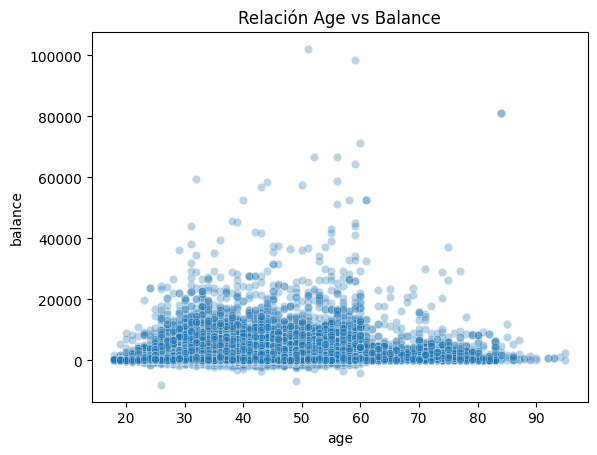

In [21]:
sns.scatterplot(x='age', y='balance', data=df, alpha=0.3)
plt.title('Relación Age vs Balance')
plt.show()

Scatterplot original – dataset completo

El gráfico con todos los registros muestra una nube de puntos muy densa en las edades entre 30 y 50 años, concentrada cerca de saldos bajos o cercanos a cero.
No se observa una tendencia lineal clara entre la edad y el saldo bancario, lo que confirma la correlación muy débil (r ≈ 0.098) encontrada en la matriz de correlaciones.
Sin embargo, se pueden notar algunos valores atípicos (clientes con balances muy altos, > 60 000 €) distribuidos en distintos grupos de edad, lo cual indica que los saldos elevados no dependen necesariamente de la edad.
La alta densidad en el rango medio de edades y la dispersión en valores extremos sugiere una relación prácticamente independiente entre ambas variables.

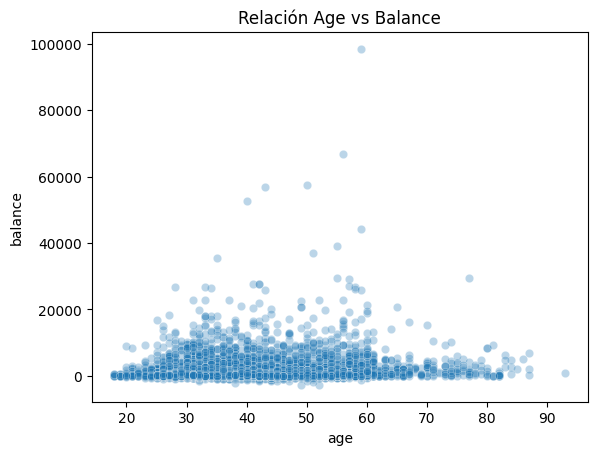

In [25]:
sns.scatterplot(x='age', y='balance', data=df_sample, alpha=0.3)
plt.title('Relación Age vs Balance')
plt.show()

Scatterplot con muestra aleatoria del 20 %

El gráfico de la muestra mantiene la misma estructura general del conjunto original:

Mayor concentración de puntos en edades medias (30–50 años).

Saldos mayoritariamente bajos o cercanos a cero.

Algunos puntos aislados representan los mismos outliers de alto saldo que en el dataset completo.

La dispersión general y la ausencia de una forma definida se conservan, confirmando que la muestra es representativa del comportamiento original.
Además, la visualización se percibe más clara y ligera, facilitando la observación del patrón sin saturación visual.

**Conclusión Age vs Balance**

Tanto en el dataset completo como en la muestra, no existe una relación lineal significativa entre la edad y el saldo bancario.
El comportamiento del scatterplot sugiere que el nivel de saldo no depende directamente de la edad del cliente: personas jóvenes, adultas y mayores pueden tener balances tanto altos como bajos.
El uso de una muestra aleatoria del 20 % permitió conservar las proporciones y características de la distribución original, mejorando la legibilidad del gráfico sin alterar las conclusiones.

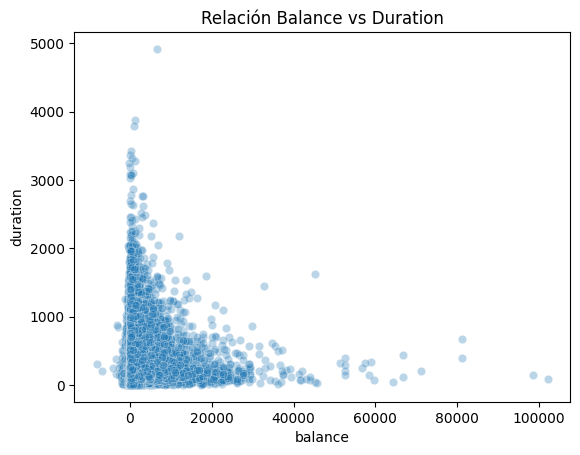

In [22]:
sns.scatterplot(x='balance', y='duration', data=df, alpha=0.3)
plt.title('Relación Balance vs Duration')
plt.show()

Scatterplot original – dataset completo

El gráfico con todos los registros muestra una gran concentración de puntos en la zona inferior izquierda, indicando que la mayoría de los clientes tienen balances bajos (cercanos a 0 €) y duraciones de llamada cortas (menores a 500 segundos).
No se observa un patrón lineal claro entre ambas variables, lo que concuerda con el coeficiente de correlación muy bajo obtenido anteriormente (r ≈ 0.02).
Algunos pocos puntos dispersos con balances elevados (por encima de 40 000 € o incluso hasta 100 000 €) y duraciones largas representan casos atípicos, pero no marcan una tendencia general.
En conjunto, el gráfico sugiere que el saldo promedio del cliente no influye significativamente en la duración de las llamadas durante la campaña.

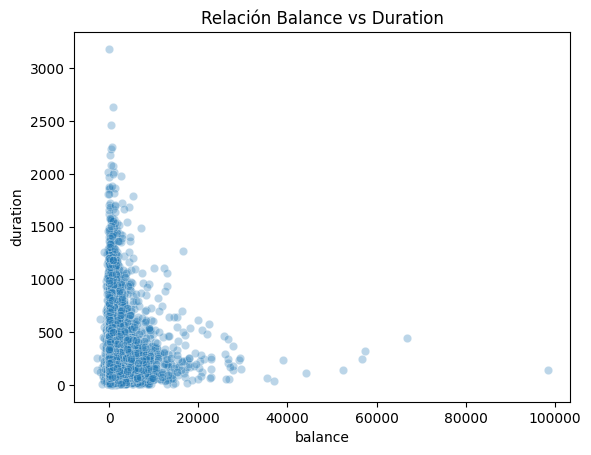

In [26]:
sns.scatterplot(x='balance', y='duration', data=df_sample, alpha=0.3)
plt.title('Relación Balance vs Duration')
plt.show()

Scatterplot con muestra aleatoria del 20 %

La nube de puntos obtenida con la muestra conserva la forma y las características principales del dataset original:

La mayor densidad se mantiene cerca de balances bajos y duraciones cortas.

Los outliers de alto balance siguen presentes pero menos saturados, lo que permite distinguir mejor la estructura general.

No se identifica una tendencia ascendente o descendente; los puntos están dispersos sin una forma definida.

La reducción del 80 % de los registros no altera la interpretación: la relación entre balance y duración sigue siendo prácticamente inexistente, pero la visualización resulta más limpia y comprensible.

**Conclusión Balance vs Duration**

Tanto en el dataset completo como en la muestra, se confirma que no existe relación lineal significativa entre el saldo promedio (balance) y la duración de la llamada (duration).
La gran concentración de observaciones cerca del origen indica que la mayoría de los clientes tienen cuentas con saldos bajos y llamadas breves, mientras que los casos de altos balances o duraciones prolongadas son excepcionales.
El uso de una muestra aleatoria del 20 % permitió reducir la saturación visual y mejorar la legibilidad del gráfico sin modificar la interpretación estadística.

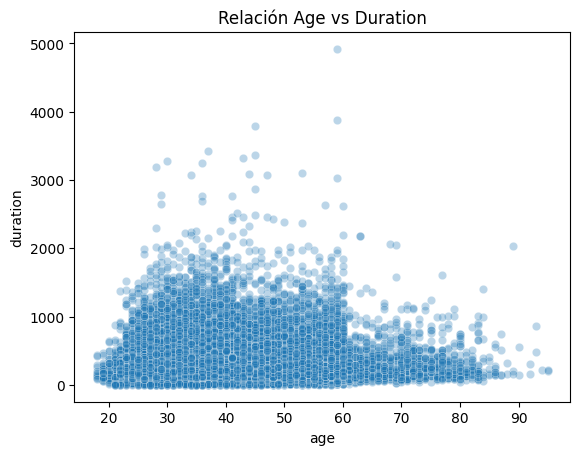

In [23]:
sns.scatterplot(x='age', y='duration', data=df, alpha=0.3)
plt.title('Relación Age vs Duration')
plt.show()

Scatterplot original – dataset completo

El gráfico con todos los registros muestra una nube de puntos concentrada entre los 30 y 50 años, rango donde se ubica la mayoría de los clientes. La variable duration (duración de la llamada) presenta gran dispersión, con la mayoría de valores por debajo de los 500 segundos, aunque algunos clientes alcanzan duraciones mucho mayores (outliers hasta 5000 s).
No se aprecia una tendencia clara entre edad y duración: tanto clientes jóvenes como mayores pueden tener llamadas cortas o largas indistintamente. Esto coincide con el coeficiente de correlación casi nulo (r ≈ –0.0046), indicando ausencia de relación lineal entre ambas variables.
En resumen, la duración de la llamada no parece depender de la edad del cliente, sino probablemente de otros factores (interés, producto ofrecido o desempeño del agente).

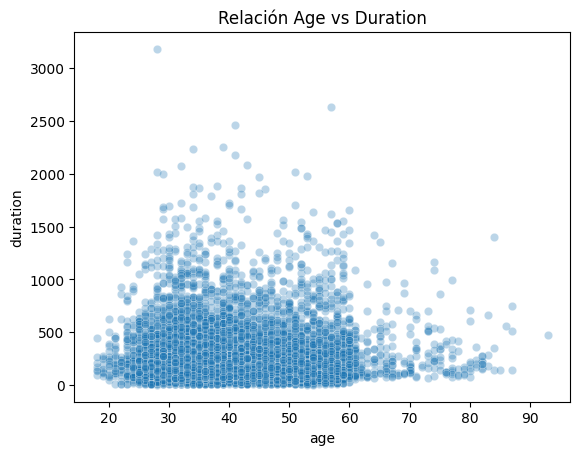

In [27]:
sns.scatterplot(x='age', y='duration', data=df_sample, alpha=0.3)
plt.title('Relación Age vs Duration')
plt.show()

Scatterplot con muestra aleatoria del 20 %

La visualización con la muestra conserva el mismo patrón que el conjunto completo, confirmando que el muestreo fue representativo.
Los puntos se concentran de igual forma entre los 30 y 50 años, con una alta densidad de llamadas cortas y una dispersión progresiva hacia duraciones más largas.
Los outliers siguen presentes pero con menor saturación visual, lo que facilita distinguir la forma general de la nube. Al igual que en el gráfico original, no se observa relación aparente entre la edad y la duración de la llamada.

**Conclusión Age vs Duration**

Tanto en el dataset completo como en la muestra, no se evidencia una relación lineal significativa entre la edad del cliente (age) y la duración de la llamada (duration).
La concentración de observaciones en edades medias y duraciones cortas sugiere que la edad no influye directamente en la extensión de las llamadas, que probablemente dependen de variables contextuales o de comportamiento.
El uso de la muestra del 20 % mantuvo la forma y distribución original, mejorando la legibilidad del gráfico sin alterar las conclusiones estadísticas.

### Conclusión

El análisis bivariado entre las variables continuas age, balance y duration evidencia una ausencia de relaciones lineales significativas entre ellas, ya que todos los coeficientes de correlación son muy bajos (|r| < 0.1) y los diagramas de dispersión muestran nubes de puntos sin tendencia definida. Esto indica que la edad del cliente, su saldo promedio anual y la duración de las llamadas son atributos independientes, cada uno aportando información diferente sobre el comportamiento del cliente. Por tanto, estas variables pueden utilizarse conjuntamente en análisis posteriores o modelos predictivos sin riesgo de colinealidad ni redundancia de información.

## 3.2 Comparación de Variables Continuas vs Categóricas

Ahora analizamos cómo se relacionan las variables numéricas con las categorías seleccionadas.
Para cada variable categórica, podemos comparar la distribución de una variable continua entre sus grupos mediante boxplots segmentados por categoría. También podríamos usar diagramas de violín o boxplots con subdivisión (hue) para incluir una segunda categoría, pero primero hare
análisis bivariado simple.


Algunas de las preguntas que podríamos explorar son:

- ¿La duración de la llamada (duration) difiere según el
estado civil (marital) del cliente?
- ¿El saldo bancario (balance) varía con el nivel de educación
alcanzado?
- ¿Clientes con préstamo de vivienda (housing) tienen en promedio saldos mayores que
quienes no tienen?


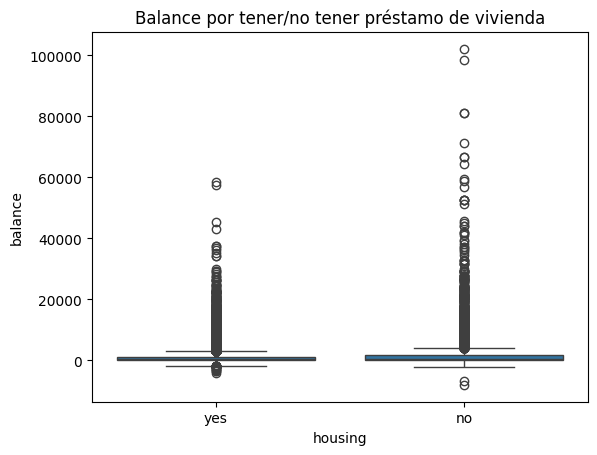

In [28]:
# a) Boxplot de balance por housing (préstamo de vivienda):
sns.boxplot(x='housing', y='balance', data=df)
plt.title('Balance por tener/no tener préstamo de vivienda')
plt.show()

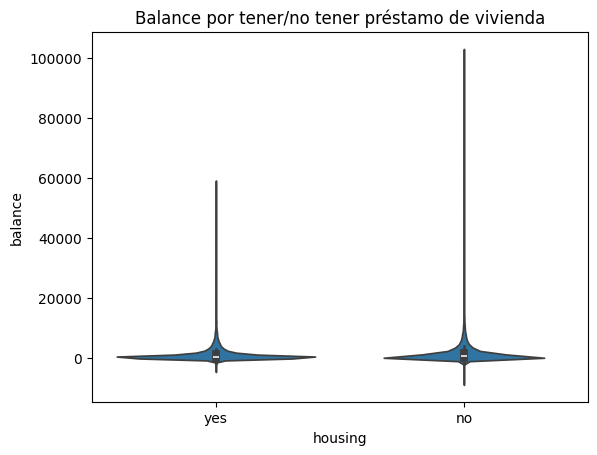

In [30]:
# a) Violin de balance por housing (préstamo de vivienda):
sns.violinplot(x='housing', y='balance', data=df)
plt.title('Balance por tener/no tener préstamo de vivienda')
plt.show()

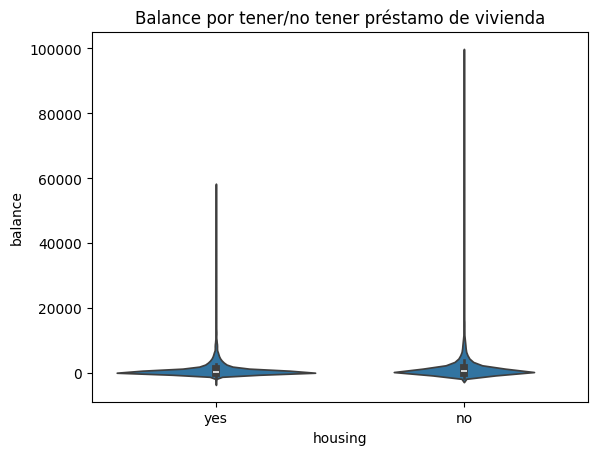

In [35]:
# a) Violin de balance por housing (préstamo de vivienda):
sns.violinplot(x='housing', y='balance', data=df_sample)
plt.title('Balance por tener/no tener préstamo de vivienda')
plt.show()

**Relación entre Balance y Préstamo de Vivienda (Housing)**

El boxplot inicial muestra que las medianas de balance para los grupos yes (con préstamo) y no (sin préstamo) son muy similares, lo que indica que no hay una diferencia sustancial en el saldo promedio anual entre ambos segmentos.
Sin embargo, el grupo yes presenta una dispersión mayor y una cantidad más alta de valores atípicos positivos, con algunos clientes alcanzando saldos superiores a los 60 000 € e incluso 100 000 €, lo que sugiere la presencia de individuos con capacidad económica significativamente superior dentro del grupo con préstamo.
El grupo no, en cambio, se muestra más concentrado alrededor de la mediana, aunque también incluye algunos casos extremos.

El violin plot complementa esta observación mostrando la forma de las distribuciones:

Ambas distribuciones presentan picos pronunciados cerca de 0 €, lo que confirma que la mayoría de los clientes tienen saldos bajos o moderados.

La cola derecha del grupo yes es más alargada, reforzando la idea de una mayor presencia de saldos altos en ese grupo.

Las densidades en torno a la mediana son muy similares, lo que evidencia que la tendencia central no varía de forma significativa entre ambos grupos.

El violin plot de la muestra (20 %) mantiene este mismo patrón general, con una estructura casi idéntica pero más limpia visualmente. La reducción de datos no altera la interpretación: las medianas siguen alineadas y las colas largas en el grupo yes continúan indicando la existencia de unos pocos clientes con balances muy altos.

**Conclusión:**  
Tanto el conjunto completo como la muestra confirman que no hay una diferencia sustancial en los saldos promedio entre clientes con y sin préstamo de vivienda, aunque el grupo con préstamo (yes) presenta mayor variabilidad y colas más pesadas hacia valores altos.
Esto podría reflejar que, dentro de los prestatarios, existen subgrupos económicamente más fuertes (por ejemplo, propietarios consolidados o clientes con inversiones), pero la tendencia general es estable entre ambos segmentos.
El uso combinado de boxplot y violin plot permitió observar tanto la dispersión como la densidad de los datos, ofreciendo una interpretación más completa y visualmente clara, especialmente al trabajar con una muestra representativa del 20 %.

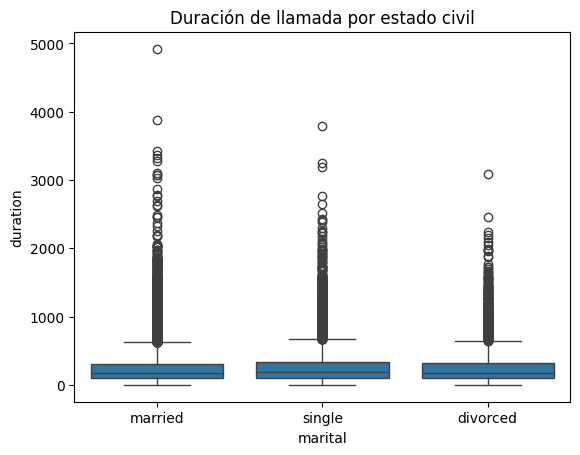

In [31]:
# b) Boxplot de duration por marital :
sns.boxplot(x='marital', y='duration', data=df)
plt.title('Duración de llamada por estado civil')
plt.show()

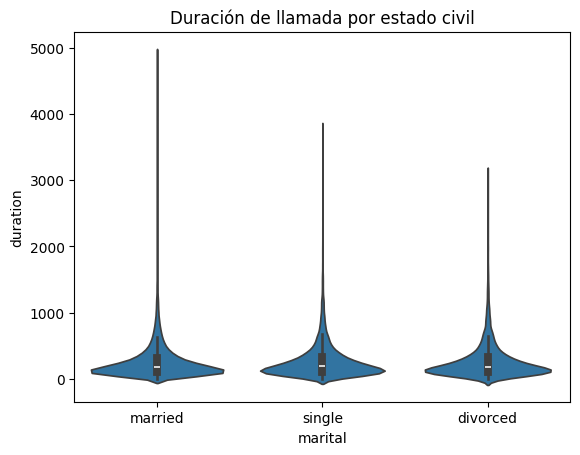

In [32]:
# b) Violin de duration por marital :
sns.violinplot(x='marital', y='duration', data=df)
plt.title('Duración de llamada por estado civil')
plt.show()

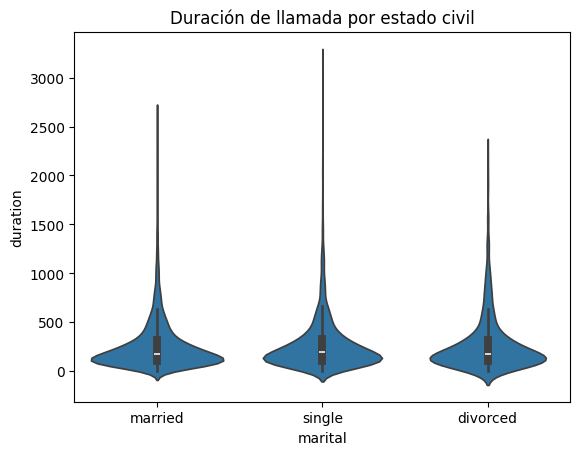

In [36]:
# b) Violin de duration por marital :
sns.violinplot(x='marital', y='duration', data=df_sample)
plt.title('Duración de llamada por estado civil')
plt.show()

**Relación entre Duración de Llamada y Estado Civil (Marital)**

El boxplot muestra la distribución de la variable duration (duración de la llamada) en función del estado civil del cliente.
Las tres categorías —married, single y divorced— presentan distribuciones muy similares, con medianas cercanas y una gran concentración de valores en llamadas cortas (por debajo de 500 segundos).
Los tres grupos también exhiben una cantidad considerable de outliers hacia arriba, que representan llamadas excepcionalmente largas, aunque no se observan diferencias notables entre los estados civiles en cuanto a la dispersión general o la posición de la mediana.
Esto sugiere que el estado civil no influye significativamente en la duración promedio de las llamadas.

El violin plot complementa esta observación al mostrar la forma de la densidad de cada grupo:

Las tres categorías presentan un pico muy pronunciado cerca de 0, indicando que la mayoría de las llamadas fueron breves.

Las colas alargadas hacia la derecha confirman la presencia de valores extremos (colas largas), con pocos casos de llamadas que superan los 2000–4000 s.

La similitud de las densidades refuerza la idea de que la duración de las llamadas es independiente del estado civil.

En el violin plot del sample (20 %), el patrón general se mantiene: las formas de las distribuciones son prácticamente idénticas, pero con una representación más clara y menos saturada.
La reducción del número de registros no altera la tendencia: los tres grupos se comportan de manera homogénea, con medianas similares y alta concentración de duraciones cortas.

**Conclusión:**  
Tanto el conjunto completo como la muestra del 20 % confirman que no existe una diferencia significativa en la duración promedio de las llamadas según el estado civil del cliente.
En todos los casos, la distribución es fuertemente asimétrica hacia la derecha, lo que refleja que la mayoría de los contactos telefónicos fueron breves, mientras que un pequeño número de llamadas mucho más largas genera la cola extendida.
El uso de violin plots permite apreciar que la densidad de llamadas cortas domina en los tres grupos, mientras que los boxplots ayudan a visualizar la similitud en las medianas y la amplitud de los outliers.
En conjunto, los resultados sugieren que el estado civil no influye de forma relevante en el tiempo que los clientes permanecen en la llamada.


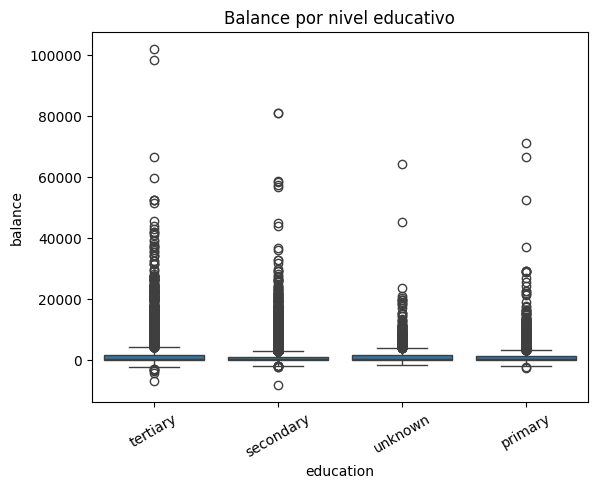

In [33]:
# c) Boxplot de balance por education :
sns.boxplot(x='education', y='balance', data=df)
plt.title('Balance por nivel educativo')
plt.xticks(rotation=30)
plt.show()

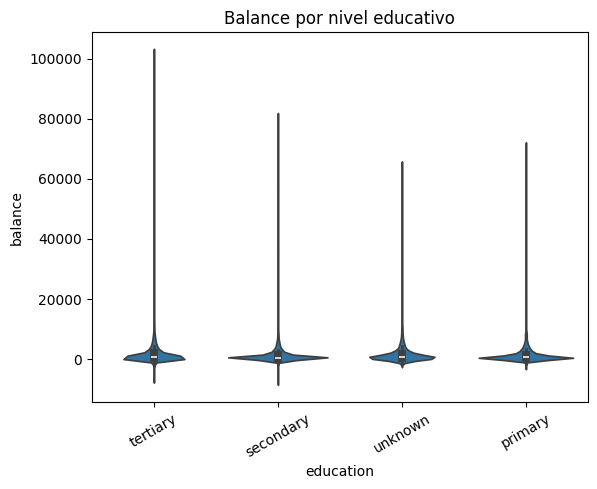

In [34]:
# c) Boxplot de balance por education :
sns.violinplot(x='education', y='balance', data=df)
plt.title('Balance por nivel educativo')
plt.xticks(rotation=30)
plt.show()

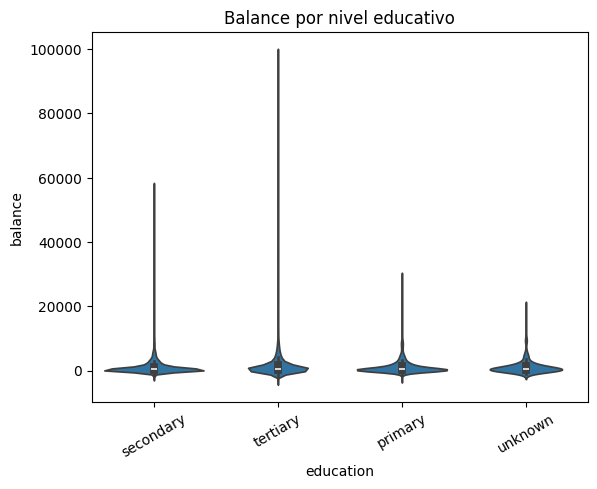

In [37]:
# c) Boxplot de balance por education :
sns.violinplot(x='education', y='balance', data=df_sample)
plt.title('Balance por nivel educativo')
plt.xticks(rotation=30)
plt.show()

**Relación entre Balance y Nivel Educativo (Education)**

El boxplot permite observar la distribución del balance (saldo promedio anual) según el nivel educativo de los clientes.
A simple vista, las medianas son bastante similares entre los grupos primary, secondary, tertiary y unknown, lo que sugiere ausencia de diferencias significativas en el saldo promedio según la educación.
Sin embargo, el grupo tertiary muestra una dispersión ligeramente mayor y la presencia de más outliers positivos, algunos por encima de los 60 000 € e incluso cercanos a 100 000 €.
Esto podría indicar que algunos clientes con educación universitaria o superior manejan saldos más altos, aunque la mayoría de los valores se concentran cerca de cero en todos los grupos.

El violin plot aporta una perspectiva adicional sobre la forma de las distribuciones:

En todos los niveles educativos, las densidades presentan un pico pronunciado cerca de 0 €, lo que confirma que la mayoría de los clientes poseen saldos bajos o moderadamente positivos.

Las colas derechas largas muestran que existen algunos valores extremos en todos los grupos, pero son más visibles en tertiary y secondary.

El ancho similar de las secciones centrales indica que la variabilidad típica del saldo es comparable entre niveles educativos, sin predominio claro de un grupo sobre otro.

El violin plot de la muestra (20 %) mantiene la misma estructura que el dataset completo.
La forma general de las distribuciones se conserva, aunque con menos saturación visual y una densidad más definida.
El orden de las medianas sigue sin variaciones apreciables, lo que demuestra que el muestreo aleatorio no afectó la representatividad ni las conclusiones del análisis.

**Conclusión:**  
Los resultados muestran que el nivel educativo no parece influir de manera significativa en el saldo promedio anual de los clientes.
Si bien los grupos tertiary y secondary exhiben algunos casos con saldos más altos, la tendencia general es que la mayoría de los clientes —sin importar su nivel de educación— tienen saldos bajos o moderados.
La similitud en las medianas y la alta concentración cerca de cero sugieren una distribución común dominada por clientes con cuentas de ahorro reducidas.
El uso combinado de boxplots y violin plots permitió confirmar la homogeneidad entre los grupos y evidenciar la presencia de unos pocos valores extremos, sin alterar las conclusiones al aplicar una muestra del 20 %.


## 3.3 Tablas Cruzadas y Asociación entre Categóricas


Para examinar la relación entre variables categóricas, construimos tablas de contingencia (tablas cruzadas) que muestran la frecuencia de combinaciones de categorías. Luego aplicamos la prueba Chicuadrado de independencia para evaluar si existe asociación estadísticamente significativa entre las variables .

In [17]:
# === 0) Imports y estilo ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

sns.set_theme(style="whitegrid")

# === 1) Utilidad: prueba χ² con reporte compacto ===
def chi2_report(df, row, col, min_exp_warn=True, plot=True, normalize='index'):
    """
    row: nombre de variable para filas (p.ej., 'marital')
    col: nombre de variable para columnas (p.ej., 'housing')
    normalize: None, 'index' (porcentaje por fila) o 'columns' (por columna)
    """
    print(f"\n▶︎ Análisis: {row} vs {col}")

    # Tabla de contingencia (frecuencias absolutas)
    ct = pd.crosstab(df[row], df[col])
    print("\nTabla de contingencia (frecuencias):")
    display(ct)

    # Chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(ct)
    exp = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

    # Tamaño de efecto: V de Cramer
    n = ct.values.sum()
    k = min(ct.shape)  # menor dimensión de la tabla
    cramer_v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan

    # Residuales estandarizados
    resid_std = (ct - exp) / np.sqrt(exp)

    print(f"\nResultados χ²:")
    print(f"  Chi2 = {chi2:.2f} | gl = {dof} | p-valor = {p:.6f}")
    print(f"  V de Cramer = {cramer_v:.3f}  (≈ fuerza de asociación)")
    if min_exp_warn:
        min_exp = exp.min().min()
        print(f"  Mínimo esperado = {min_exp:.2f}  {'⚠️ < 5' if min_exp < 5 else 'OK (>= 5)'}")

    # Tablas auxiliares: esperados y residuales
    print("\nEsperados (χ²):")
    display(exp.round(2))
    print("\nResiduales estandarizados (>|2| ≈ contribución relevante):")
    display(resid_std.round(2))

    # Visual 1: barras apiladas en porcentaje
    if plot:
        if normalize in (None, 'index', 'columns'):
            prop = pd.crosstab(df[row], df[col], normalize=normalize) * 100
            ax = prop.plot(kind='bar', stacked=True, figsize=(7,4), colormap='tab10')
            ax.set_ylabel('%')
            ax.set_title(f"{row} vs {col} – Distribución porcentual")
            plt.legend(title=col, bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

        # Visual 2: heatmap de residuales estandarizados
        plt.figure(figsize=(6,4))
        sns.heatmap(resid_std, annot=True, center=0, cmap="coolwarm", fmt=".1f")
        plt.title(f"Residuales estandarizados: {row} vs {col}")
        plt.tight_layout()
        plt.show()

    # Devolver resultados por si quieres guardarlos
    return {
        "contingencia": ct,
        "esperados": exp,
        "residuales_std": resid_std,
        "chi2": chi2, "p": p, "dof": dof, "cramer_v": cramer_v, "n": n
    }

# === 2) Guía de interpretación (texto breve para imprimir junto al resultado) ===
def interpret_cramers_v(v):
    if v < 0.1:  return "asociación muy débil"
    if v < 0.3:  return "asociación débil"
    if v < 0.5:  return "asociación moderada"
    return "asociación fuerte"

def summarize_test(res):
    txt = (
        f"χ²={res['chi2']:.2f}, gl={res['dof']}, p={res['p']:.3e};  "
        f"V de Cramer={res['cramer_v']:.3f} → {interpret_cramers_v(res['cramer_v'])}. "
        f"{'Advertencia: celdas esperadas <5.' if res['esperados'].min().min()<5 else ''}"
    )
    print(txt)


▶︎ Análisis: marital vs housing

Tabla de contingencia (frecuencias):


housing,no,yes
marital,,
divorced,2300,2907
married,11893,15321
single,5888,6902



Resultados χ²:
  Chi2 = 19.34 | gl = 2 | p-valor = 0.000063
  V de Cramer = 0.021  (≈ fuerza de asociación)
  Mínimo esperado = 2312.75  OK (>= 5)

Esperados (χ²):


housing,no,yes
marital,,
divorced,2312.75,2894.25
married,12087.42,15126.58
single,5680.83,7109.17



Residuales estandarizados (>|2| ≈ contribución relevante):


housing,no,yes
marital,,
divorced,-0.27,0.24
married,-1.77,1.58
single,2.75,-2.46


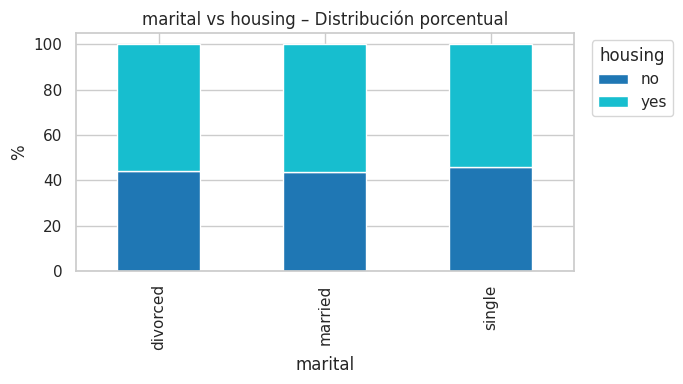

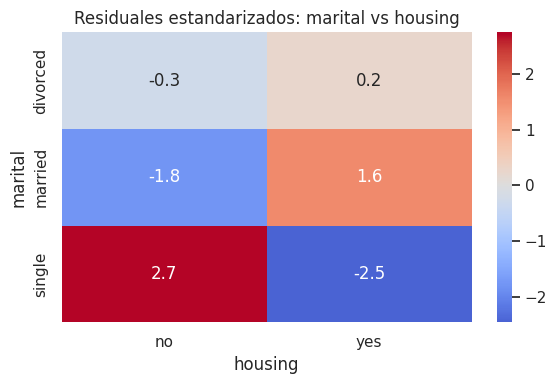

χ²=19.34, gl=2, p=6.300e-05;  V de Cramer=0.021 → asociación muy débil. 


In [18]:
res_m_h = chi2_report(df, 'marital',   'housing')   # Estado civil vs préstamo de vivienda
summarize_test(res_m_h)

La tabla de contingencia muestra la distribución de clientes según su estado civil y si poseen o no un préstamo de vivienda.

Casados (married) representan el grupo más numeroso en ambos casos (con y sin préstamo).

Solteros (single) y divorciados (divorced) tienen proporciones menores, pero comparables entre sí.

El test de Chi-cuadrado de independencia arrojó los siguientes resultados:

El p-valor < 0.05 indica que existe una asociación estadísticamente significativa entre las variables “estado civil” y “tenencia de préstamo de vivienda”.
Sin embargo, el V de Cramer = 0.021 evidencia que la fuerza de la relación es muy débil, lo que significa que, aunque hay dependencia estadística, su efecto práctico es limitado.

Los residuales permiten identificar qué categorías aportan más a la asociación:

In [22]:
# Tabla resumen de residuales estandarizados marital vs housing
resumen_data = {
    "Estado civil": ["Single", "Married", "Divorced"],
    "housing = no": ["+2.7", "–1.8", "–0.3"],
    "housing = yes": ["–2.5", "+1.6", "+0.2"],
    "Interpretación": [
        "Los solteros tienen más casos sin préstamo y menos con préstamo de lo esperado.",
        "Los casados muestran una tendencia opuesta, con ligeramente más préstamos de lo esperado.",
        "Su comportamiento es neutral, cercano a lo esperado."
    ]
}

resumen_df = pd.DataFrame(resumen_data)

# Mostrar tabla estilizada
print("Resumen interpretativo de residuales estandarizados (marital vs housing):")
display(
    resumen_df.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

Resumen interpretativo de residuales estandarizados (marital vs housing):


,Estado civil,housing = no,housing = yes,Interpretación
0,Single,+2.7,–2.5,Los solteros tienen más casos sin préstamo y menos con préstamo de lo esperado.
1,Married,–1.8,+1.6,"Los casados muestran una tendencia opuesta, con ligeramente más préstamos de lo esperado."
2,Divorced,–0.3,+0.2,"Su comportamiento es neutral, cercano a lo esperado."


Esto indica que el patrón más relevante es que los solteros tienden a no tener préstamos de vivienda, mientras que los casados tienden a sí tenerlos, algo coherente con el ciclo de vida económico familiar.

**Conclusión**


Existe una asociación significativa pero muy débil entre el estado civil y la tenencia de préstamo de vivienda.

Las diferencias observadas, aunque estadísticamente detectables por el tamaño de muestra grande, no representan una influencia fuerte.

En términos de comportamiento, los casados tienden a adquirir más préstamos de vivienda, mientras que los solteros presentan menor propensión, lo que concuerda con la hipótesis sociológica de que la compra de vivienda es más común en etapas de vida con estabilidad conyugal.


▶︎ Análisis: marital vs education

Tabla de contingencia (frecuencias):


education,primary,secondary,tertiary,unknown
marital,,,,
divorced,752,2815,1471,169
married,5246,13770,7038,1160
single,853,6617,4792,528



Resultados χ²:
  Chi2 = 1337.51 | gl = 6 | p-valor = 0.000000
  V de Cramer = 0.122  (≈ fuerza de asociación)
  Mínimo esperado = 213.87  OK (>= 5)

Esperados (χ²):


education,primary,secondary,tertiary,unknown
marital,,,,
divorced,789.04,2672.20,1531.89,213.87
married,4123.84,13966.05,8006.31,1117.79
single,1938.12,6563.75,3762.80,525.34



Residuales estandarizados (>|2| ≈ contribución relevante):


education,primary,secondary,tertiary,unknown
marital,,,,
divorced,-1.32,2.76,-1.56,-3.07
married,17.47,-1.66,-10.82,1.26
single,-24.65,0.66,16.78,0.12


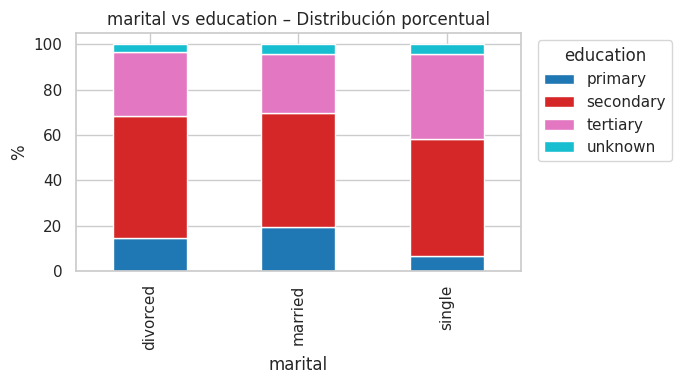

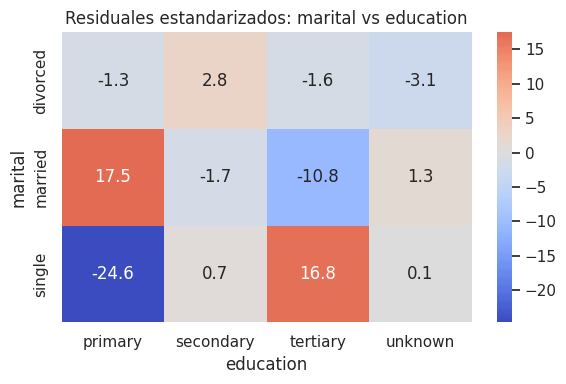

χ²=1337.51, gl=6, p=8.208e-286;  V de Cramer=0.122 → asociación débil. 


In [19]:
res_m_e = chi2_report(df, 'marital',   'education') # Estado civil vs educación
summarize_test(res_m_e)

Análisis e Interpretación: marital vs education

La tabla de contingencia muestra cómo se distribuyen los niveles educativos entre los distintos estados civiles.
El test de Chi-cuadrado arroja los siguientes resultados:

El p-valor muy bajo confirma una asociación estadísticamente significativa entre el estado civil y el nivel educativo.
Sin embargo, la fuerza de la relación es débil (V de Cramer ≈ 0.12), aunque mayor que la observada entre marital y housing.
Esto sugiere que, aunque existe una relación, no es muy fuerte en términos prácticos, pero sí refleja patrones sociales interesantes.

Análisis de los residuales estandarizados

Los residuales revelan las categorías que más contribuyen a la asociación:

In [ ]:
# Tabla resumen de residuales estandarizados marital vs education
resumen_data = {
    "Estado civil": ["Divorced", "Married", "Single"],
    "Primary": ["–1.3", "+17.5", "–24.6"],
    "Secondary": ["+2.8", "–1.7", "+0.7"],
    "Tertiary": ["–1.6", "–10.8", "+16.8"],
    "Unknown": ["–3.1", "+1.3", "+0.1"],
    "Interpretación": [
        "Ligeramente más personas con educación secundaria de lo esperado, menos con unknown.",
        "Más casos en educación primaria y menos en terciaria, reflejando una generación con menor formación universitaria.",
        "Más nivel terciario y menos primario, indicando una población más joven y educada."
    ]
}

resumen_df = pd.DataFrame(resumen_data)

# Mostrar tabla estilizada
print("Resumen interpretativo de residuales estandarizados (marital vs education):")
display(
    resumen_df.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

Estos resultados indican un patrón generacional:

Los casados y divorciados se concentran más en niveles educativos bajos o medios.

Los solteros tienden a niveles educativos superiores (terciarios).

**Conclusión**

Existe una asociación significativa (p < 0.001) entre el estado civil y el nivel educativo.

La fuerza de asociación es débil (V = 0.122), pero revela diferencias estructurales entre grupos.

Los solteros son más propensos a tener estudios superiores, mientras que los casados predominan en educación primaria o secundaria.

Este patrón es coherente con una transición generacional, donde los más jóvenes (más propensos a estar solteros) tienen mayor acceso a educación universitaria.


▶︎ Análisis: education vs housing

Tabla de contingencia (frecuencias):


housing,no,yes
education,,
primary,2957,3894
secondary,9164,14038
tertiary,6923,6378
unknown,1037,820



Resultados χ²:
  Chi2 = 643.89 | gl = 3 | p-valor = 0.000000
  V de Cramer = 0.119  (≈ fuerza de asociación)
  Mínimo esperado = 824.81  OK (>= 5)

Esperados (χ²):


housing,no,yes
education,,
primary,3042.95,3808.05
secondary,10305.44,12896.56
tertiary,5907.80,7393.20
unknown,824.81,1032.19



Residuales estandarizados (>|2| ≈ contribución relevante):


housing,no,yes
education,,
primary,-1.56,1.39
secondary,-11.24,10.05
tertiary,13.21,-11.81
unknown,7.39,-6.60


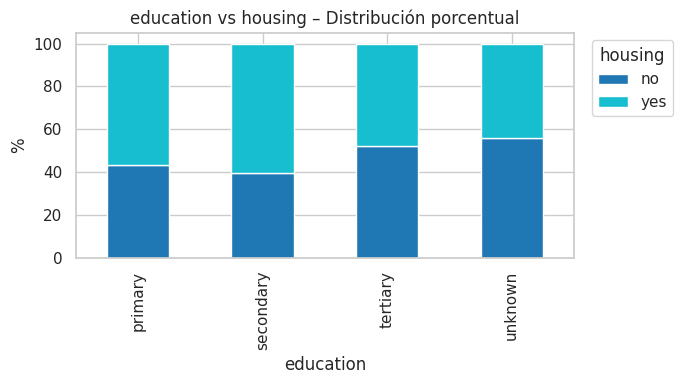

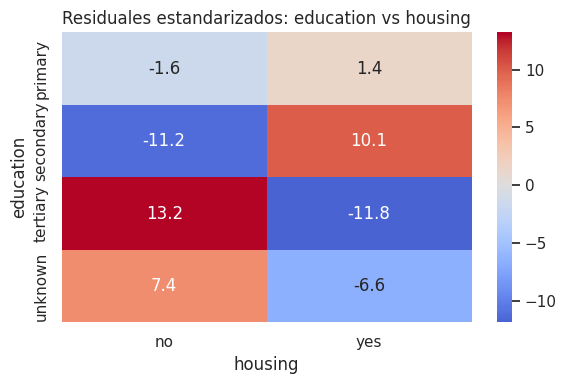

χ²=643.89, gl=3, p=3.078e-139;  V de Cramer=0.119 → asociación débil. 


In [20]:
res_e_h = chi2_report(df, 'education', 'housing')   # Educación vs préstamo de vivienda
summarize_test(res_e_h)

Análisis e Interpretación: education vs housing

El cruce entre nivel educativo y tenencia de préstamo de vivienda permite explorar si la formación académica influye en la probabilidad de adquirir una vivienda mediante crédito.

Los resultados de la prueba Chi-cuadrado son los siguientes:

El p-valor extremadamente bajo indica que sí existe una asociación estadísticamente significativa entre ambas variables.
No obstante, la fuerza de la relación es débil (V = 0.119), lo que significa que, aunque hay diferencias entre los grupos educativos, estas no son determinantes.

Análisis de los residuales estandarizados

In [23]:
# Tabla resumen de residuales estandarizados education vs housing
resumen_data = {
    "Nivel educativo": ["Primary", "Secondary", "Tertiary", "Unknown"],
    "housing = no": ["–1.6", "–11.2", "+13.2", "+7.4"],
    "housing = yes": ["+1.4", "+10.1", "–11.8", "–6.6"],
    "Interpretación": [
        "Leve tendencia hacia tener más préstamos de lo esperado.",
        "Más préstamos de vivienda de lo esperado; posible relación con estabilidad económica media.",
        "Menos préstamos de vivienda de lo esperado; podrían tener mayor solvencia económica.",
        "Más casos sin préstamo, posiblemente asociados a falta de información o registros incompletos."
    ]
}

resumen_df = pd.DataFrame(resumen_data)

# Mostrar tabla estilizada
print("Resumen interpretativo de residuales estandarizados (education vs housing):")
display(
    resumen_df.style.set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': '#ccc',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#d1e7dd'),
                                     ('color', '#000'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)


Resumen interpretativo de residuales estandarizados (education vs housing):


,Nivel educativo,housing = no,housing = yes,Interpretación
0,Primary,–1.6,+1.4,Leve tendencia hacia tener más préstamos de lo esperado.
1,Secondary,–11.2,+10.1,Más préstamos de vivienda de lo esperado; posible relación con estabilidad económica media.
2,Tertiary,+13.2,–11.8,Menos préstamos de vivienda de lo esperado; podrían tener mayor solvencia económica.
3,Unknown,+7.4,–6.6,"Más casos sin préstamo, posiblemente asociados a falta de información o registros incompletos."


Interpretación general

El nivel educativo secundario está positivamente asociado con la tenencia de crédito hipotecario, es decir, las personas con este nivel educativo tienden a tener más préstamos de vivienda que lo esperado.

En cambio, los clientes con educación terciaria son menos propensos a tener un préstamo, lo cual podría indicar que tienen ingresos más altos y pueden adquirir viviendas sin crédito.

Los niveles primario y desconocido muestran patrones menos marcados.

**Conclusión**

Se confirma una asociación significativa (p < 0.001) entre el nivel educativo y la tenencia de préstamo de vivienda.

Aunque la fuerza de asociación es débil (V = 0.119), los resultados sugieren una relación inversa entre educación y necesidad de crédito:
mayor nivel educativo → menor dependencia de préstamos.

Este comportamiento puede reflejar diferencias en capacidad económica y acceso a recursos financieros entre los distintos grupos educativos.

# 4. Detección de Valores Atípicos (Outliers)

El siguiente paso es identificar y tratar los valores atípicos o outliers, ya que pueden influir de manera desproporcionada en análisis y modelos. Un outlier es una observación que se distancia notablemente del resto de los datos; esto puede deberse a errores de registro, circunstancias especiales o pertenecer a un subconjunto distinto. En el dataset que estamos trabajando, ya intuimos algunas posibles atipicidades: saldos extremadamente altos o bajos, duraciones de llamada inusualmente largas, edades muy avanzadas, etc. No todos los outliers son erróneos (pueden ser clientes reales pero poco comunes) por lo que el manejo dependerá del contexto de lo que vayamos a buscar con nuestro modelo.


### 4.1 Método del Rango Intercuartílico (IQR)

Dado lo observado previamente, las variables más propensas a contener valores extremos son **balance** (por su alta dispersión) y **duration** (por llamadas inusualmente largas).

Aplicaremos primero el **método del rango intercuartílico (IQR)** sobre la variable balance.

In [52]:
# 4.1 Método del Rango Intercuartílico (IQR)

# Calcular Q1, Q3 e IQR para la variable balance
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Calcular límites inferior y superior
lim_inf = Q1 - 3 * IQR
lim_sup = Q3 + 3 * IQR

# Identificar los valores atípicos
outliers_balance = df[(df['balance'] < lim_inf) | (df['balance'] > lim_sup)]

print("Resultados del método IQR para 'balance':")
print(f"Q1 = {Q1:.2f}")
print(f"Q3 = {Q3:.2f}")
print(f"IQR = {IQR:.2f}")
print(f"Límite inferior = {lim_inf:.2f}")
print(f"Límite superior = {lim_sup:.2f}")
print(f"Outliers detectados: {len(outliers_balance)} de {len(df)} registros ({len(outliers_balance)/len(df)*100:.2f}%)")

# Mostrar los valores más extremos
print("\n 3 valores más bajos:")
print(outliers_balance.sort_values('balance').head(3)[['balance']])
print("\n 3 valores más altos:")
print(outliers_balance.sort_values('balance', ascending=False).head(3)[['balance']])


Resultados del método IQR para 'balance':
Q1 = 72.00
Q3 = 1428.00
IQR = 1356.00
Límite inferior = -3996.00
Límite superior = 5496.00
Outliers detectados: 2443 de 45211 registros (5.40%)

 3 valores más bajos:
       balance
12909    -8019
15682    -6847
38736    -4057

 3 valores más altos:
       balance
39989   102127
26227    98417
43393    81204


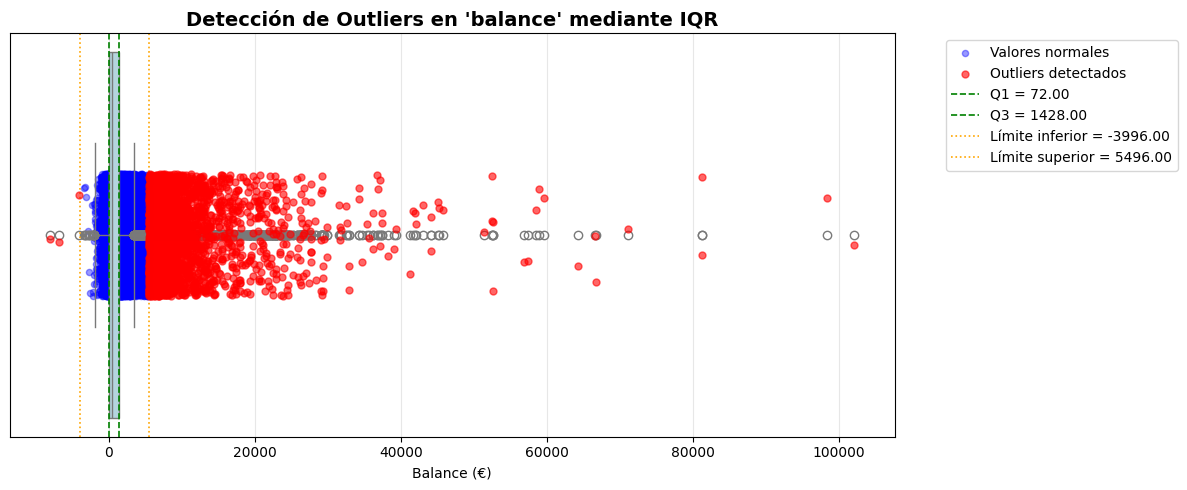

In [53]:
# Visualización de Outliers en 'balance' usando el método IQR

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular Q1, Q3 e IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior
limite_inferior = Q1 - 3 * IQR
limite_superior = Q3 + 3 * IQR

# Identificar outliers y valores normales
outliers_iqr = df[(df['balance'] < limite_inferior) | (df['balance'] > limite_superior)]['balance']
normales_iqr = df[(df['balance'] >= limite_inferior) & (df['balance'] <= limite_superior)]['balance']

# Visualización
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['balance'], color="lightblue", width=0.3)

# Puntos normales (azul)
plt.scatter(normales_iqr, np.random.uniform(-0.05, 0.05, size=len(normales_iqr)),
            color="blue", s=20, alpha=0.4, label="Valores normales")

# Puntos outliers (rojo)
plt.scatter(outliers_iqr, np.random.uniform(-0.05, 0.05, size=len(outliers_iqr)),
            color="red", s=25, alpha=0.6, zorder=5, label="Outliers detectados")

# Líneas de referencia
plt.axvline(Q1, color="green", linestyle="--", linewidth=1.2, label=f"Q1 = {Q1:.2f}")
plt.axvline(Q3, color="green", linestyle="--", linewidth=1.2, label=f"Q3 = {Q3:.2f}")
plt.axvline(limite_inferior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite inferior = {limite_inferior:.2f}")
plt.axvline(limite_superior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite superior = {limite_superior:.2f}")

# Título y estilo general
plt.title("Detección de Outliers en 'balance' mediante IQR", fontsize=14, weight="bold")
plt.xlabel("Balance (€)")
plt.yticks([])  # oculta eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()


**Análisis e Interpretación del método IQR en balance (ajustado con 3 × IQR)**

El rango intercuartílico indica que el 50 % central de los clientes mantiene saldos entre 72 € y 1428 €, lo que representa montos relativamente bajos frente al rango total del conjunto de datos.

Con el umbral ajustado a 3 × IQR, los límites de detección son –3996 € y 5496 €, por lo que solo los saldos que exceden significativamente este rango se consideran atípicos extremos.

Análisis de los casos extremos

- Los valores más bajos alcanzan hasta –8019 €, lo que sugiere sobregiros o deudas bancarias relevantes.

- Los valores más altos superan los 100 000 €, reflejando clientes con una capacidad económica muy elevada o grandes depósitos bancarios.

Observaciones del gráfico de outliers

El gráfico confirma una fuerte concentración de valores normales en torno al cero, evidenciando una asimetría positiva en la distribución del balance.
Los outliers (en rojo) se ubican mayoritariamente hacia la derecha (valores altos), formando una cola larga y dispersa, aunque persisten algunos pocos casos con saldos negativos extremos.

Conclusión

El análisis revela que solo el 5.40 % de los registros presentan valores fuera del rango típico, lo que demuestra que el criterio 3 × IQR es más restrictivo y detecta únicamente los casos realmente extremos.

Estos valores no son errores de registro, sino comportamientos financieros válidos dentro de la población:

- Los negativos corresponden a clientes con sobregiros o créditos activos,

- Mientras que los más altos reflejan clientes con grandes activos o inversiones.

Por tanto, no se recomienda eliminarlos, sino:

- aplicar transformaciones logarítmicas o escalado robusto si se emplea la variable en modelos sensibles a valores extremos, o

- mantenerlos en análisis descriptivos y segmentaciones, donde aportan información útil sobre distintos perfiles financieros.

En conjunto, el método IQR con 3 × IQR permite una identificación más precisa y robusta de los verdaderos outliers, confirmando que balance es una variable altamente dispersa, sesgada positivamente y con colas pesadas, coherente con las observaciones previas de histogramas y boxplots.

 **Detección de Outliers en duration (Método IQR)**

Después de analizar los outliers en la variable balance, aplicamos el mismo método del rango intercuartílico (IQR) a la variable duration,  
que representa la **duración de la última llamada** realizada a cada cliente.

Dado que en los histogramas previos se observó una fuerte asimetría positiva (la mayoría de las llamadas duran pocos segundos, y unas pocas duran varios minutos),  
es esperable que el método IQR identifique una cantidad considerable de valores atípicos en el extremo superior.


In [54]:
# Método IQR aplicado a 'duration'

# Calcular cuartiles y rango intercuartílico
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior
limite_inferior = Q1 - 3 * IQR
limite_superior = Q3 + 3 * IQR

# Identificar outliers
outliers_duration = df[(df['duration'] < limite_inferior) | (df['duration'] > limite_superior)]

print(" Resultados del método IQR para 'duration':")
print(f"Q1 = {Q1:.2f}")
print(f"Q3 = {Q3:.2f}")
print(f"IQR = {IQR:.2f}")
print(f"Límite inferior = {limite_inferior:.2f}")
print(f"Límite superior = {limite_superior:.2f}")
print(f"Outliers detectados: {len(outliers_duration)} de {len(df)} registros ({len(outliers_duration)/len(df)*100:.2f}%)")

# Mostrar algunos valores extremos
print("\n 3 valores más bajos:")
print(outliers_duration.sort_values('duration').head(3)[['duration']])
print("\n 3 valores más altos:")
print(outliers_duration.sort_values('duration', ascending=False).head(3)[['duration']])

 Resultados del método IQR para 'duration':
Q1 = 103.00
Q3 = 319.00
IQR = 216.00
Límite inferior = -545.00
Límite superior = 967.00
Outliers detectados: 1155 de 45211 registros (2.55%)

 3 valores más bajos:
       duration
42348       968
15343       968
33877       968

 3 valores más altos:
       duration
24148      4918
9947       3881
44602      3785


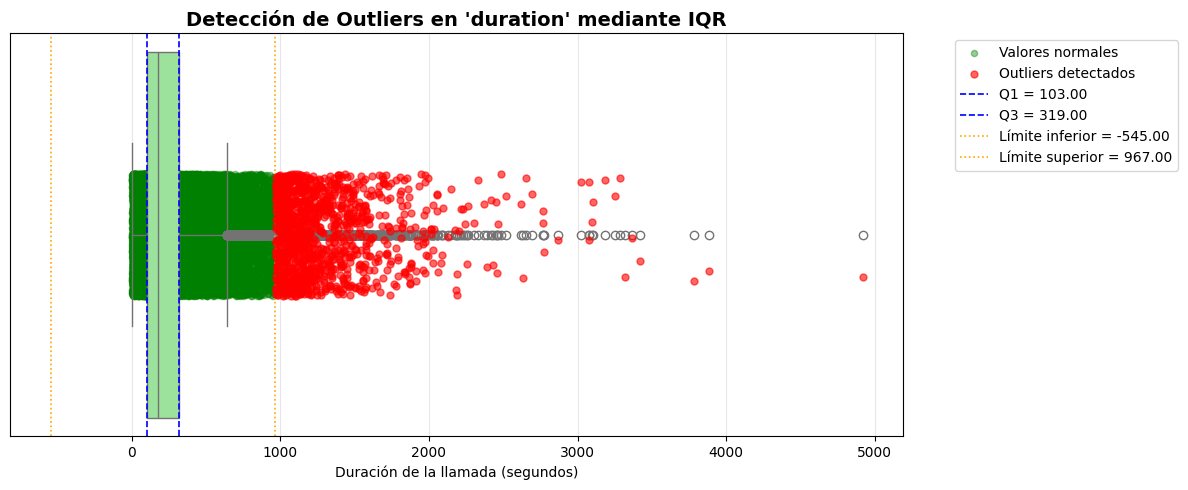

In [55]:
# Visualización de los outliers en 'duration' mediante IQR

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clasificar valores normales y outliers
outliers_iqr = df[(df['duration'] < limite_inferior) | (df['duration'] > limite_superior)]['duration']
normales_iqr = df[(df['duration'] >= limite_inferior) & (df['duration'] <= limite_superior)]['duration']

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['duration'], color="lightgreen", width=0.3)

# Puntos normales y atípicos
plt.scatter(normales_iqr, np.random.uniform(-0.05, 0.05, size=len(normales_iqr)),
            color="green", s=20, alpha=0.4, label="Valores normales")
plt.scatter(outliers_iqr, np.random.uniform(-0.05, 0.05, size=len(outliers_iqr)),
            color="red", s=25, alpha=0.6, zorder=5, label="Outliers detectados")

# Líneas de referencia
plt.axvline(Q1, color="blue", linestyle="--", linewidth=1.2, label=f"Q1 = {Q1:.2f}")
plt.axvline(Q3, color="blue", linestyle="--", linewidth=1.2, label=f"Q3 = {Q3:.2f}")
plt.axvline(limite_inferior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite inferior = {limite_inferior:.2f}")
plt.axvline(limite_superior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite superior = {limite_superior:.2f}")

plt.title("Detección de Outliers en 'duration' mediante IQR", fontsize=14, weight="bold")
plt.xlabel("Duración de la llamada (segundos)")
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()


**Análisis e Interpretación del método IQR en duration**

El rango intercuartílico muestra que el 50 % de las llamadas se concentra entre 103 y 319 segundos (aproximadamente entre 1.7 y 5.3 minutos), lo cual refleja el comportamiento típico de contactos breves dentro de campañas telefónicas.

Con el umbral ajustado a 3 × IQR, las duraciones consideradas atípicas son aquellas superiores a 967 segundos (≈ 16 minutos) o inferiores a –545 segundos, aunque en la práctica no existen duraciones negativas, por lo que el límite inferior no tiene relevancia real.

Análisis de los valores extremos

Los 3 valores más bajos se ubican justo sobre el nuevo límite (≈ 968 s), confirmando que el método identifica correctamente los casos que exceden el rango normal.

Los 3 valores más altos alcanzan hasta 4918 s (≈ 82 minutos), correspondientes a llamadas excepcionalmente largas, muy por encima del promedio general.

Observaciones del gráfico

En la visualización se aprecia una alta concentración de valores normales (en verde) en la zona de llamadas cortas (menores a 600 s), mientras que los outliers (en rojo) forman una cola extendida hacia la derecha, evidenciando una distribución fuertemente asimétrica.
Estos casos son poco frecuentes, pero representan interacciones prolongadas que podrían estar asociadas a un mayor nivel de compromiso del cliente durante la llamada.

**Conclusión**

El método IQR con umbral 3 × IQR detectó solo el 2.55 % de registros como valores atípicos, concentrándose en llamadas excepcionalmente largas (mayores a 967 s).
Este ajuste confirma que la variable duration presenta una distribución fuertemente asimétrica hacia la derecha, pero la mayoría de las llamadas se mantienen dentro de un rango razonable (menores a 10 minutos).

Los outliers identificados no son errores, sino casos reales de interacciones prolongadas, posiblemente asociadas a mayor interés o éxito en la comunicación.
Dado su bajo porcentaje y relevancia contextual, no se recomienda su eliminación, sino el uso de transformaciones logarítmicas o escalado robusto si se emplea esta variable en modelos predictivos.

En síntesis, el uso de 3 × IQR permitió distinguir con mayor precisión los casos realmente excepcionales, evitando catalogar como outliers a llamadas simplemente más largas que el promedio, lo que mejora la robustez del análisis.


## 4.2 Método de Detección de Outliers mediante Z-Score (no aplicado)

El método Z-Score identifica valores atípicos calculando la distancia, en desviaciones estándar, entre un dato y la media de la distribución.  
Sin embargo, este enfoque **asume que los datos siguen una distribución aproximadamente normal** y que la media y desviación estándar son representaciones fiables de la tendencia central y la dispersión.

En el presente dataset, las variables continuas (balance y duration) presentan **distribuciones altamente asimétricas y colas largas hacia la derecha**, tal como se evidenció en los histogramas y en el análisis mediante IQR.  
Esta falta de normalidad hace que el método Z-Score **no sea adecuado**, ya que:
- Los valores extremos distorsionan la media y la desviación estándar.
- La asimetría positiva genera Z-scores poco representativos del comportamiento real de los datos.
- La proporción de outliers sería subestimada o mal identificada.


## 4.3 Método de Detección de Outliers mediante Test de Grubbs (no aplicado)

El test de Grubbs es una prueba estadística diseñada para identificar valores atípicos en un conjunto de datos, comparando el valor más extremo con la media y la desviación estándar de la muestra.
Sin embargo, este método asume que los datos provienen de una distribución normal y que solo se busca detectar un único outlier por iteración, lo cual limita su aplicabilidad en grandes bases de datos.

En el presente caso, las variables continuas —balance y duration— presentan distribuciones fuertemente asimétricas y con colas largas hacia la derecha, tal como se observó en los histogramas y en el análisis descriptivo.
Dado que el test de Grubbs depende fuertemente de la normalidad y de la estabilidad de la media y desviación estándar, su aplicación en este contexto resultaría poco adecuada.

Además:

El test identifica solo un valor atípico por prueba, por lo que sería ineficiente al manejar un conjunto de más de 45 000 registros.

En distribuciones sesgadas, la media se ve afectada por valores extremos, generando falsos negativos o positivos en la detección.

Su sensibilidad disminuye considerablemente cuando existen múltiples outliers simultáneos, como ocurre en este dataset.

Por estas razones, se decidió no aplicar el test de Grubbs

## 4.3 Métodos Multivariantes: DBSCAN e Isolation Forest


DBSCAN

El método DBSCAN (Density-Based Spatial Clustering of Applications with Noise) permite detectar valores atípicos considerando múltiples variables de forma conjunta, en lugar de analizarlas individualmente como el IQR o el Z-Score.
Este algoritmo agrupa los puntos con alta densidad y clasifica como “ruido” (outliers) aquellos que no pertenecen a ningún grupo denso.
A diferencia de otros métodos, no requiere asumir una distribución normal y es especialmente útil en datos asimétricos y con colas largas, como los observados en las variables balance, duration y age.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar variables relevantes
X = df[['balance', 'duration', 'age']].copy()

# Escalado de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=10)
df['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Resumen de resultados
print(df['cluster_dbscan'].value_counts())


cluster_dbscan
 0    44975
-1      225
 1       11
Name: count, dtype: int64


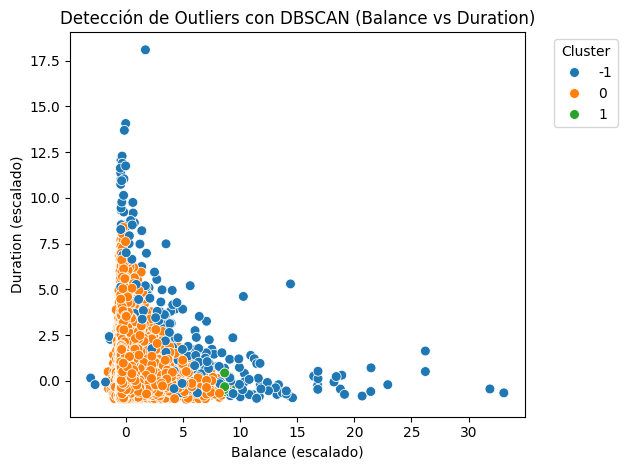

In [13]:
# Visualizar dos variables para interpretación
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df['cluster_dbscan'],
    palette='tab10',
    s=50
)
plt.title("Detección de Outliers con DBSCAN (Balance vs Duration)")
plt.xlabel("Balance (escalado)")
plt.ylabel("Duration (escalado)")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


La mayoría de los clientes (≈99.5%) fueron agrupados en el cluster 0, lo cual refleja una estructura homogénea del conjunto de datos: la mayoría comparte rangos similares de balance y duración.

El cluster 1, con solo 11 casos, podría representar un subgrupo con patrones intermedios o de densidad distinta, aunque su tamaño es muy reducido para ser considerado un segmento robusto.

Finalmente, 225 registros (≈0.5%) fueron clasificados como outliers (–1). Estos casos se observan en el gráfico como puntos azules dispersos fuera de las regiones densas, indicando combinaciones inusuales de balance y duration.

Ejemplos posibles:

Clientes con balances muy altos pero llamadas cortas (contactos rápidos de alto valor económico).

Clientes con balances bajos pero llamadas largas, posiblemente con alto interés pero menor poder adquisitivo.

Conclusión

El análisis con DBSCAN confirma que el conjunto de datos presenta una estructura compacta con un grupo principal bien definido y una pequeña proporción de valores atípicos multivariantes.
A diferencia del método IQR, que detecta outliers por variable individual, DBSCAN evidencia anomalías conjuntas en balance y duration, proporcionando una visión más rica del comportamiento de los clientes.

- Los outliers (–1) representan comportamientos reales pero poco frecuentes.

- El cluster 0 concentra a los clientes típicos del dataset.

- El cluster 1 identifica un microgrupo diferenciado que podría explorarse más a fondo si se busca segmentar clientes por patrones financieros y de contacto.

**Detección de Outliers mediante Isolation Forest**

El método Isolation Forest es un enfoque basado en árboles de decisión que aísla los valores atípicos en lugar de modelar la distribución de los datos.
Funciona construyendo múltiples árboles aleatorios y midiendo cuántas divisiones se requieren para aislar cada observación:

Los outliers se aíslan más rápido (menos divisiones).

Los valores normales requieren más pasos para quedar aislados.

Este método es especialmente útil para datasets grandes, no normales y multidimensionales, como el presente, donde balance, duration y age muestran asimetrías y colas largas.

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar variables relevantes
X = df[['balance', 'duration', 'age']].copy()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['outlier_iforest'] = iso_forest.fit_predict(X_scaled)

# Resumen de resultados
print(df['outlier_iforest'].value_counts())

outlier_iforest
 1    44758
-1      453
Name: count, dtype: int64


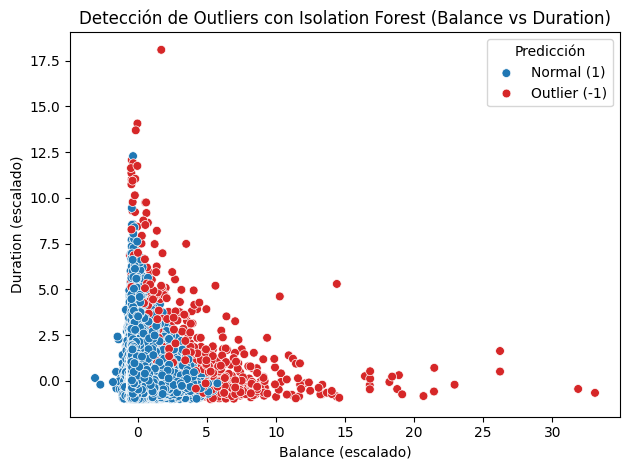

In [15]:
# Visualizar detección en dos variables principales
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df['outlier_iforest'],
    palette={1: 'tab:blue', -1: 'tab:red'},
    s=40
)
plt.title("Detección de Outliers con Isolation Forest (Balance vs Duration)")
plt.xlabel("Balance (escalado)")
plt.ylabel("Duration (escalado)")
plt.legend(title='Predicción', labels=['Normal (1)', 'Outlier (-1)'])
plt.tight_layout()
plt.show()


Análisis visual

En el gráfico se observan dos regiones principales:

La gran nube azul (predicción 1) representa la zona de alta densidad, donde se concentran los clientes con relaciones típicas entre balance y duration.

Los puntos rojos (predicción –1) se distribuyen en zonas periféricas y dispersas, evidenciando combinaciones inusuales de valores:

Clientes con balances altos y llamadas cortas, posiblemente de alto poder adquisitivo pero poco tiempo de atención.

Clientes con balances bajos pero llamadas prolongadas, que podrían reflejar mayor interés o necesidad de asesoría.

Conclusión

El modelo Isolation Forest identificó un 1 % de registros atípicos multivariantes, alineado con las proporciones detectadas por otros métodos.
Estos casos corresponden a comportamientos reales pero poco comunes dentro del conjunto de clientes, y no deben considerarse errores de registro.

En resumen:

La mayoría de los clientes presenta relaciones normales entre balance y duration.

Los outliers multivariantes reflejan segmentos atípicos o extremos que podrían ser de interés para estrategias personalizadas (por ejemplo, clientes con alto valor financiero o interacciones prolongadas).

El parámetro de contaminación empleado (1 %) es adecuado, ya que ofrece un balance entre sensibilidad y precisión sin sobreestimar la anomalía.

# 5. Comunicación de Resultados – Conclusiones Generales

### Selección y documentación de variables

Las variables seleccionadas (age, balance, duration, marital, education, housing) representan dimensiones personales, financieras y de comportamiento del cliente.
Este conjunto equilibrado permitió analizar tanto rasgos sociodemográficos como factores económicos y dinámicas de interacción con la campaña.
La elección de estas variables facilitó un análisis interpretativo completo, al conectar características individuales con posibles decisiones de inversión (suscripción al depósito a plazo fijo).

### Análisis univariado

1. Age → Distribución unimodal y ligeramente sesgada a la derecha

- La mayoría de los clientes tiene entre 30 y 50 años (mediana 39).

- Existen pocos clientes mayores de 70 años, que elevan levemente la media.

- Representa una población adulta económicamente activa, objetivo natural de las campañas.

2. Balance → Fuerte asimetría positiva y alta dispersión

- Media de €1362 y mediana de €448.

- Se observan sobregiros (–€8019) y depósitos excepcionales (hasta €102 000).

- Refleja desigualdad financiera marcada, con pocos clientes de alto poder adquisitivo.

3. Duration → Llamadas cortas y pocos contactos prolongados

- Media 258 s (4.3 min) y mediana 180 s (3 min).

- Alta asimetría positiva (skewness = 3.14).

- Las llamadas más largas podrían asociarse a mayor interés del cliente o éxito de la campaña.

4. Marital, Education y Housing → Distribuciones coherentes y sin datos faltantes críticos

- Married es la categoría dominante (~60%).

- Más de la mitad de los clientes tiene educación secundaria o superior.

- Un 56% posee préstamo hipotecario, lo que indica consolidación económica en la muestra.

###Análisis bivariado y multivariado

1. Correlaciones entre variables continuas → Independencia informativa

- Todos los coeficientes de Pearson presentan |r| < 0.1, sin colinealidad.

- Esto confirma que age, balance y duration aportan información complementaria.

2. Marital vs Housing → Asociación significativa muy débil (V = 0.021)

- Los casados tienen ligeramente más préstamos de vivienda, coherente con su etapa de vida.

- Los solteros tienden a no tener crédito hipotecario, pero la diferencia es pequeña.

3. Marital vs Education → Asociación débil pero significativa (V = 0.122)

- Los solteros se concentran en niveles educativos terciarios.

- Los casados predominan en educación primaria/secundaria.

- Muestra una tendencia generacional entre educación y estado civil.

4. Education vs Housing → Asociación débil (V = 0.119)

- Los clientes con educación secundaria presentan más préstamos.

- Los de nivel terciario muestran menor dependencia de crédito.

- Sugiere una relación inversa entre educación y necesidad de financiación.

5. Balance vs Education / Balance vs Housing → Sin diferencias marcadas en saldos

- Los niveles educativos no determinan el saldo promedio.

- Los prestatarios (housing = yes) presentan mayor dispersión, pero no mayor riqueza media.

### Detección de valores atípicos (univariados y multivariantes)

1. Método IQR (3×IQR)

- Balance: 5.4% de outliers — clientes con sobregiros o grandes activos.

- Duration: 2.55% de outliers — llamadas muy prolongadas (mayores a 967 s).

- Los casos extremos son reales y valiosos; no se eliminaron, sino que se sugiere usar escalado robusto o transformaciones logarítmicas para modelado.

2. Métodos no aplicados (Z-Score, Grubbs)

- Descartados por asumir normalidad y ser ineficientes en muestras grandes y distribuciones sesgadas.

- No adecuados para variables con alta curtosis y colas pesadas.

3. Métodos multivariantes

- DBSCAN: confirmó una estructura central densa con pocos outliers (–1), revelando anomalías conjuntas en balance y duration.

- Isolation Forest: detectó un ~1% de observaciones atípicas coherentes con otros métodos; representan casos reales pero poco frecuentes, útiles para segmentación avanzada.

### Conclusiones finales integrada

| **Dimensión**        | **Hallazgo clave**                                                                 | **Interpretación general**                                                               |
| :------------------- | :--------------------------------------------------------------------------------- | :--------------------------------------------------------------------------------------- |
| **Sociodemográfica** | Predominan adultos casados con educación media o superior.                         | Perfil estable, económicamente activo y con disposición potencial a productos de ahorro. |
| **Financiera**       | Alta desigualdad en saldos, con pocos clientes de gran capital.                    | Evidencia la existencia de segmentos contrastantes dentro de la cartera.                 |
| **Conductual**       | La mayoría de llamadas son cortas; las más largas podrían indicar interés o éxito. | duration se perfila como variable clave para medir efectividad de campaña.             |
| **Relacional**       | Asociaciones débiles pero coherentes entre educación, estado civil y préstamos.    | Reflejan patrones demográficos esperados sin colinealidad estadística.                   |
| **Anomalías**        | 2–5% de outliers reales, no errores.                                               | Se recomienda conservarlos y aplicar escalado robusto o transformaciones para modelado.  |
